# Stage IV Indiv: Andrew Van Es

Utilize Linear and Non-Linear (polynomial with degree n) regression models to compare trends for a single state (each member should choose different state) and its counties (top 5 with highest number of cases). Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday).

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt

# important imports for our regression models.
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.svm import SVR


# reading in our main Covid Data set.
df = pd.read_csv("Data/ProjectDataStage1WIDEFORMAT.csv")
df.head()

,Unnamed: 0,countyFIPS,County Name,State,population,2020-01-22_Cases,2020-01-23_Cases,2020-01-24_Cases,2020-01-25_Cases,2020-01-26_Cases,...,2023-07-14_Deaths,2023-07-15_Deaths,2023-07-16_Deaths,2023-07-17_Deaths,2023-07-18_Deaths,2023-07-19_Deaths,2023-07-20_Deaths,2023-07-21_Deaths,2023-07-22_Deaths,2023-07-23_Deaths
0,0,0,Statewide Unallocated,AL,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1001,Autauga County,AL,55869,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,235
2,2,1003,Baldwin County,AL,223234,0,0,0,0,0,...,731,731,731,731,731,731,731,731,731,731
3,3,1005,Barbour County,AL,24686,0,0,0,0,0,...,104,104,104,104,104,104,104,104,104,104
4,4,1007,Bibb County,AL,22394,0,0,0,0,0,...,111,111,111,111,111,111,111,111,111,111


#### We'll start by manipulating our data into a form in which we need it, for our linear and non-linear regressions. At the same time we will be isolating the top 5 counties in the state of GA.

In [2]:
# dfmod = df.copy(deep=True)

df_ga_mod = df.copy(deep=True)
df_ga_mod = df_ga_mod[df_ga_mod['State'] == 'GA']

# Create a list for our Date range of 2020-06-01 to 2021-01-03. 
col_list = [j for j in df.columns if (('2020-01-22' <= j < '2020-06-01') or ('2021-01-11' <= j)) 
    and (('Cases' in j) or ('Deaths' in j))]

# Drop all columns not in our date range list.
df_ga_mod.drop(columns=col_list, inplace=True)

# split the cases and deaths data into two seperate dataframes
c_ga_df = df_ga_mod.filter(like='Cases', axis=1)
d_ga_df = df_ga_mod.filter(like='Deaths', axis=1)

# Test dataframe to test look for high numbers of cases in each county
# Sort the data frame to see the to five highest case counts.
ga_test = df_ga_mod[['County Name', '2021-01-03_Cases']].copy(deep=True)
ga_test.sort_values(by='2021-01-03_Cases',ascending=False).head()

,County Name,2021-01-03_Cases
464,Greene County,53549
457,Franklin County,52709
430,Clinch County,38473
441,Decatur County,36546
466,Habersham County,17925


In [3]:
# Createing an df with the top 5 counties case numbers
df_ga_c = c_ga_df.T[[464, 457, 430, 441, 466]]
df_ga_c = df_ga_c.T
df_ga_c.head()

,2020-06-01_Cases,2020-06-02_Cases,2020-06-03_Cases,2020-06-04_Cases,2020-06-05_Cases,2020-06-06_Cases,2020-06-07_Cases,2020-06-08_Cases,2020-06-09_Cases,2020-06-10_Cases,...,2021-01-01_Cases,2021-01-02_Cases,2021-01-03_Cases,2021-01-04_Cases,2021-01-05_Cases,2021-01-06_Cases,2021-01-07_Cases,2021-01-08_Cases,2021-01-09_Cases,2021-01-10_Cases
464,3874,3919,4122,4323,4414,4433,4535,4652,4751,4908,...,52473,53046,53549,53884,54733,55152,55999,57219,58089,58870
457,4626,4659,4690,4773,4793,4822,4845,4911,4964,5021,...,51701,52375,52709,53080,53675,53907,54932,56031,56719,57483
430,3052,3063,3119,3180,3225,3238,3262,3322,3348,3431,...,37510,38095,38473,38817,39208,39556,40118,41077,41747,42242
441,3799,3828,3901,3964,3985,4008,4035,4083,4167,4214,...,35976,36360,36546,36692,37141,37480,37870,38429,39043,39487
466,2505,2517,2543,2575,2598,2615,2617,2655,2677,2692,...,17708,17843,17925,18081,18270,18479,18633,18881,19134,19291


In [4]:
# Createing an df with the top 5 counties death numbers
df_ga_d = d_ga_df.T[[464, 457, 430, 441, 466]]
df_ga_d = df_ga_d.T
df_ga_d.head()

,2020-06-01_Deaths,2020-06-02_Deaths,2020-06-03_Deaths,2020-06-04_Deaths,2020-06-05_Deaths,2020-06-06_Deaths,2020-06-07_Deaths,2020-06-08_Deaths,2020-06-09_Deaths,2020-06-10_Deaths,...,2021-01-01_Deaths,2021-01-02_Deaths,2021-01-03_Deaths,2021-01-04_Deaths,2021-01-05_Deaths,2021-01-06_Deaths,2021-01-07_Deaths,2021-01-08_Deaths,2021-01-09_Deaths,2021-01-10_Deaths
464,132,134,135,136,136,137,137,142,142,145,...,565,565,565,565,566,570,571,574,583,584
457,241,244,250,250,250,252,252,271,271,272,...,739,739,740,742,744,748,752,759,763,763
430,182,185,189,193,193,193,193,202,203,212,...,555,555,555,556,565,574,575,577,583,583
441,121,121,122,122,122,125,125,132,134,137,...,495,495,495,497,500,503,505,506,508,508
466,49,50,50,50,50,50,50,50,52,53,...,222,222,222,222,230,232,236,238,242,242


In [5]:
# tried using index, was causing issues with a function used later.
#dfc_Greene = df_ga_c.T[464].copy(deep=True)

# Using our case values from the first day in the data set to make our df's
dfc_Greene = df_ga_c[df_ga_c['2020-06-01_Cases'] == 3874]#.copy(deep=True)
dfc_Frank = df_ga_c[df_ga_c['2020-06-01_Cases'] == 4626]
dfc_Clinch = df_ga_c[df_ga_c['2020-06-01_Cases'] == 3052]
dfc_Decat = df_ga_c[df_ga_c['2020-06-01_Cases'] == 3799]
dfc_Haber = df_ga_c[df_ga_c['2020-06-01_Cases'] == 2505]

# Using our death values from the first day in the data set to make our df's
dfd_Greene = df_ga_d[df_ga_d['2020-06-01_Deaths'] == 132]
dfd_Frank = df_ga_d[df_ga_d['2020-06-01_Deaths'] == 241]
dfd_Clinch = df_ga_d[df_ga_d['2020-06-01_Deaths'] == 182]
dfd_Decat = df_ga_d[df_ga_d['2020-06-01_Deaths'] == 121]
dfd_Haber = df_ga_d[df_ga_d['2020-06-01_Deaths'] == 49]

# data of the overall state.
covC = c_ga_df.sum(axis=0).to_frame().T.copy(deep=True)
covD = d_ga_df.sum(axis=0).to_frame().T.copy(deep=True)

# print to test if working
dfd_Greene.head()

,2020-06-01_Deaths,2020-06-02_Deaths,2020-06-03_Deaths,2020-06-04_Deaths,2020-06-05_Deaths,2020-06-06_Deaths,2020-06-07_Deaths,2020-06-08_Deaths,2020-06-09_Deaths,2020-06-10_Deaths,...,2021-01-01_Deaths,2021-01-02_Deaths,2021-01-03_Deaths,2021-01-04_Deaths,2021-01-05_Deaths,2021-01-06_Deaths,2021-01-07_Deaths,2021-01-08_Deaths,2021-01-09_Deaths,2021-01-10_Deaths
464,132,134,135,136,136,137,137,142,142,145,...,565,565,565,565,566,570,571,574,583,584


#### Here we are setting up our data of the top 5 counties with highest case amounts (in georiga) and prepaing them to be used with the linear and non lineaar regresion models using machine learning.

In [6]:
#function used to make the data sets cumulative, created back in stage II.
def Cumulative_array(array_def, begin_val):
    CumulativeArr = array_def[:, 1:] - array_def[:, :-1]
    first_column = array_def[:, 0].reshape(-1, 1)
    CumulativeArr = np.hstack((first_column, CumulativeArr))
    CumulativeArr[0, 0] = begin_val
    
    return CumulativeArr

# try and normalize the data by pop, set up the variables.
#df_casesUS_Sum['Cases'] = (df_casesUS_Sum.Cases/pop)*100000
greenePop = df.population[464]
frankPop = df.population[457]
clinchPop = df.population[430]
decatPop = df.population[441]
haberPop = df.population[466]

# calculate values later in excel
caseST = Cumulative_array(covC.to_numpy(), 200)
caseTG = Cumulative_array(dfc_Greene.to_numpy(), 200)
caseTF = Cumulative_array(dfc_Frank.to_numpy(), 200)
caseTC = Cumulative_array(dfc_Clinch.to_numpy(), 200)
caseTD = Cumulative_array(dfc_Decat.to_numpy(), 200)
caseTH = Cumulative_array(dfc_Haber.to_numpy(), 200)

# State overall
df_StateCases_Sum = pd.DataFrame(caseST.T, columns=['Cases'])
df_StateCases_Sum['Num_of_Days'] = df_StateCases_Sum.index + 1
df_StateCases_Sum['Cases'] = (df_StateCases_Sum.Cases/10617423)*1000

# counties
df_GreeneCases_Sum = pd.DataFrame(caseTG.T, columns=['Cases'])
df_GreeneCases_Sum['Num_of_Days'] = df_GreeneCases_Sum.index + 1
df_GreeneCases_Sum['Cases'] = (df_GreeneCases_Sum.Cases/greenePop)*1000

df_FrankCases_Sum = pd.DataFrame(caseTF.T, columns=['Cases'])
df_FrankCases_Sum['Num_of_Days'] = df_FrankCases_Sum.index + 1
df_FrankCases_Sum['Cases'] = (df_FrankCases_Sum.Cases/frankPop)*1000

df_ClinchCases_Sum = pd.DataFrame(caseTC.T, columns=['Cases'])
df_ClinchCases_Sum['Num_of_Days'] = df_ClinchCases_Sum.index + 1
df_ClinchCases_Sum['Cases'] = (df_ClinchCases_Sum.Cases/clinchPop)*1000

df_DecatCases_Sum = pd.DataFrame(caseTD.T, columns=['Cases'])
df_DecatCases_Sum['Num_of_Days'] = df_DecatCases_Sum.index + 1
df_DecatCases_Sum['Cases'] = (df_DecatCases_Sum.Cases/decatPop)*1000

df_HaberCases_Sum = pd.DataFrame(caseTH.T, columns=['Cases'])
df_HaberCases_Sum['Num_of_Days'] = df_HaberCases_Sum.index + 1
df_HaberCases_Sum['Cases'] = (df_HaberCases_Sum.Cases/haberPop)*1000

print(df_GreeneCases_Sum)

         Cases  Num_of_Days
0    10.914647            1
1     2.455796            2
2    11.078367            3
3    10.969221            4
4     4.966165            5
..         ...          ...
219  22.866186          220
220  46.223532          221
221  66.579349          222
222  47.478716          223
223  42.621698          224

[224 rows x 2 columns]


#### Repeat the same proces of data manipulation for the death values for the top 5 counties

In [7]:
# calculate values later in excel
deathST = covD.to_numpy()
deathTG = dfd_Greene.to_numpy() #Cumulative_array(dfd_Greene.to_numpy(), 1)
deathTF = dfd_Frank.to_numpy() #Cumulative_array(dfd_Frank.to_numpy(), 1)
deathTC = dfd_Clinch.to_numpy() #Cumulative_array(dfd_Clinch.to_numpy(), 1)
deathTD = dfd_Decat.to_numpy() #Cumulative_array(dfd_Decat.to_numpy(), 1)
deathTH = dfd_Haber.to_numpy() #Cumulative_array(dfd_Haber.to_numpy(), 1)

# state overall
df_StateDeath_Sum = pd.DataFrame(deathST.T, columns=['Cases'])
df_StateDeath_Sum['Num_of_Days'] = df_StateDeath_Sum.index + 1
df_StateDeath_Sum['Deaths'] = (df_StateDeath_Sum.Cases/10617423)*1000

# top 5 counties
df_GreeneDeath_Sum = pd.DataFrame(deathTG.T, columns=['Deaths'])
df_GreeneDeath_Sum['Num_of_Days'] = df_GreeneDeath_Sum.index + 1
df_GreeneDeath_Sum['Deaths'] = (df_GreeneDeath_Sum.Deaths/greenePop)*1000

df_FrankDeath_Sum = pd.DataFrame(deathTF.T, columns=['Deaths'])
df_FrankDeath_Sum['Num_of_Days'] = df_FrankDeath_Sum.index + 1
df_FrankDeath_Sum['Deaths'] = (df_FrankDeath_Sum.Deaths/frankPop)*1000

df_ClinchDeath_Sum = pd.DataFrame(deathTC.T, columns=['Deaths'])
df_ClinchDeath_Sum['Num_of_Days'] = df_ClinchDeath_Sum.index + 1
df_ClinchDeath_Sum['Deaths'] = (df_ClinchDeath_Sum.Deaths/clinchPop)*1000

df_DecatDeath_Sum = pd.DataFrame(deathTD.T, columns=['Deaths'])
df_DecatDeath_Sum['Num_of_Days'] = df_DecatDeath_Sum.index + 1
df_DecatDeath_Sum['Deaths'] = (df_DecatDeath_Sum.Deaths/decatPop)*1000

df_HaberDeath_Sum = pd.DataFrame(deathTH.T, columns=['Deaths'])
df_HaberDeath_Sum['Num_of_Days'] = df_HaberDeath_Sum.index + 1
df_HaberDeath_Sum['Deaths'] = (df_HaberDeath_Sum.Deaths/haberPop)*1000

df_HaberDeath_Sum.head()

,Deaths,Num_of_Days
0,1.081010,1
1,1.103071,2
2,1.103071,3
3,1.103071,4
4,1.103071,5


# State of Georgia
### Regressions and Models, prediction path, RSMV and Confidence Intervals.

In [8]:
# Used to set the date ranges and make our forcast line.
train_SC = df_StateCases_Sum[df_StateCases_Sum.Num_of_Days <= 217]
test_SC = df_StateCases_Sum

# Set our x and y values for our models for State of Georgia.
# x is number of days.
# y is number of new cases
x_SC_cases = np.array(train_SC.Num_of_Days).reshape(-1, 1)
y_SC_cases = np.array(train_SC.Cases).reshape(-1, 1)

xSC_train,xSC_test,ySC_train,ySC_test=train_test_split(x_SC_cases, y_SC_cases, test_size=0.3, random_state=42)

In [9]:
# setting up our linear model.
svr_lin_state = SVR(kernel="linear")
svr_lin_state.fit(xSC_train, ySC_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_state = SVR(kernel="poly", degree=1)
svr_poly2_state = SVR(kernel="poly", degree=2)
svr_poly3_state = SVR(kernel="poly", degree=3)
svr_poly4_state = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_state.fit(xSC_train, ySC_train.ravel())
svr_poly2_state.fit(xSC_train, ySC_train.ravel())
svr_poly3_state.fit(xSC_train, ySC_train.ravel())
svr_poly4_state.fit(xSC_train, ySC_train.ravel())

SVR(degree=4, kernel='poly')

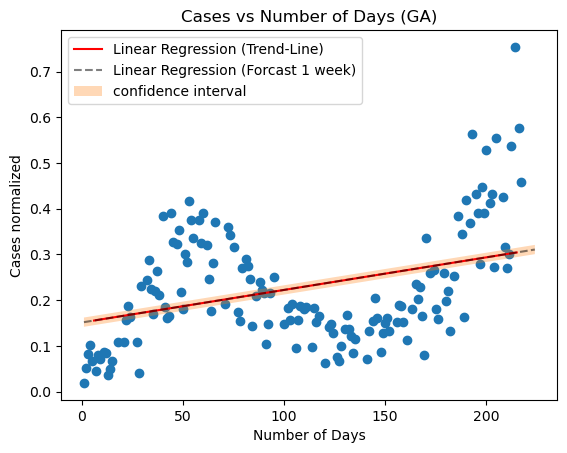

In [10]:
# this prediction is for the trend line.
ySC_pred = svr_lin_state.predict(xSC_test)

xSC_test_df = pd.DataFrame(xSC_test, columns=['xSC_test'])
ySC_lin_df = pd.DataFrame(ySC_pred, columns=['ySC_pred'])

# ploting the confidence interval
lin_state = pd.concat([xSC_test_df, ySC_lin_df], axis=1)
lin_state = lin_state.sort_values(by=['ySC_pred'], ascending=True)

# this is for the future forcast
xSC_pred = np.array(test_SC.Num_of_Days).reshape(-1, 1)
ySC1_pred = svr_lin_state.predict(xSC_pred)

xSC_pred_df = pd.DataFrame(xSC_pred, columns=['xS_pred'])
ySC_pred_df = pd.DataFrame(ySC1_pred, columns=['yS_pred'])

# used for the confidence interval
pred_state = pd.concat([xSC_pred_df, ySC_pred_df], axis=1)
pred_state = pred_state.sort_values(by=['yS_pred'], ascending=True)
# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(ySC1_pred)/np.sqrt(len(xSC_pred))) #*5

# ploting the data from GA
plt.scatter(xSC_train, ySC_train)
# trend line of the data.
plt.plot(lin_state.xSC_test, lin_state.ySC_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_state.xS_pred, pred_state.yS_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_state.xS_pred, (pred_state.yS_pred-ci), (pred_state.yS_pred+ci), alpha=.3, label="confidence interval")

plt.title('Cases vs Number of Days (GA)')
plt.xlabel('Number of Days')
plt.ylabel('Cases normalized')
plt.legend()
plt.show()

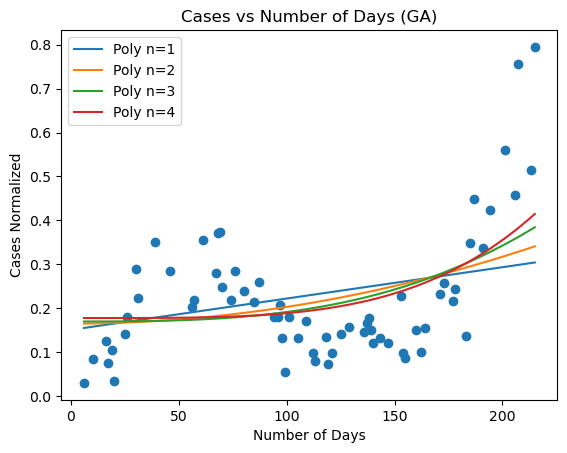

In [11]:
#make our pridict variables
ySC_predN1 = svr_poly1_state.predict(xSC_test)
ySC_predN2 = svr_poly2_state.predict(xSC_test)
ySC_predN3 = svr_poly3_state.predict(xSC_test)
ySC_predN4 = svr_poly4_state.predict(xSC_test)

# predict arrays values to dataframes.
xSC_test_df = pd.DataFrame(xSC_test, columns=['x_test'])
ySC_predN1_df = pd.DataFrame(ySC_predN1, columns=['y_predN1'])
ySC_predN2_df = pd.DataFrame(ySC_predN2, columns=['y_predN2'])
ySC_predN3_df = pd.DataFrame(ySC_predN3, columns=['y_predN3'])
ySC_predN4_df = pd.DataFrame(ySC_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_state = pd.concat([xSC_test_df, ySC_predN1_df], axis=1)
poly2_state = pd.concat([xSC_test_df, ySC_predN2_df], axis=1)
poly3_state = pd.concat([xSC_test_df, ySC_predN3_df], axis=1)
poly4_state = pd.concat([xSC_test_df, ySC_predN4_df], axis=1)

# Sort the values by the predict values.
poly1_state = poly1_state.sort_values(by=['y_predN1'], ascending=True)
poly2_state = poly2_state.sort_values(by=['y_predN2'], ascending=True)
poly3_state = poly3_state.sort_values(by=['y_predN3'], ascending=True)
poly4_state = poly4_state.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xSC_test, ySC_test)
plt.plot(poly1_state.x_test, poly1_state.y_predN1, label="Poly n=1")
plt.plot(poly2_state.x_test, poly2_state.y_predN2, label="Poly n=2")
plt.plot(poly3_state.x_test, poly3_state.y_predN3, label="Poly n=3")
plt.plot(poly4_state.x_test, poly4_state.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Cases vs Number of Days (GA)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
CS_mse = mean_squared_error(y_true=ySC_test, y_pred=ySC_pred, squared=True)
CS_rmse = mean_squared_error(y_true=ySC_test, y_pred=ySC_pred, squared=False)
print("- MSE:",CS_mse)
print("- RMSE:",CS_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
CSn1_mse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN1_df, squared=True)
CSn1_rmse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN1_df, squared=False)
print("- MSE:",CSn1_mse)
print("- RMSE:",CSn1_rmse)

# for n=2
print("\n- n=2")
CSn2_mse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN2_df, squared=True)
CSn2_rmse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN2_df, squared=False)
print("- MSE:",CSn2_mse)
print("- RMSE:",CSn2_rmse)

# for n=3
print("\n- n=3")
CSn3_mse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN3_df, squared=True)
CSn3_rmse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN3_df, squared=False)
print("- MSE:",CSn3_mse)
print("- RMSE:",CSn3_rmse)

# for n=4
print("\n- n=4")
CSn4_mse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN4_df, squared=True)
CSn4_rmse = mean_squared_error(y_true=ySC_test, y_pred=ySC_predN4_df, squared=False)
print("- MSE:",CSn4_mse)
print("- RMSE:",CSn4_rmse)


Linear Cases Regression model:

- MSE: 0.01882005021767356
- RMSE: 0.13718618814470196

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 0.01882004697340959
- RMSE: 0.13718617632039165

- n=2
- MSE: 0.016949136705352776
- RMSE: 0.13018885015757983

- n=3
- MSE: 0.014980393824623338
- RMSE: 0.12239441909099998

- n=4
- MSE: 0.013578734126197827
- RMSE: 0.11652782554479349


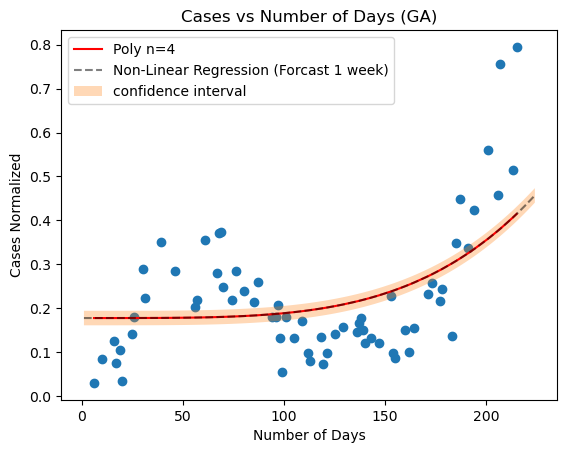

In [13]:
# this is for the future forcast
xSC_pred = np.array(test_SC.Num_of_Days).reshape(-1, 1)
ySC1_pred = svr_poly4_state.predict(xSC_pred)

xSC_pre_df = pd.DataFrame(xSC_pred, columns=['xSC_pred'])
ySC_pre_df = pd.DataFrame(ySC1_pred, columns=['ySC_pred'])

# ploting the confidence interval
pred_state = pd.concat([xSC_pre_df, ySC_pre_df], axis=1)
pred_state = pred_state.sort_values(by=['ySC_pred'], ascending=True)

# plot our values.
plt.scatter(xSC_test, ySC_test)
plt.plot(poly4_state.x_test, poly4_state.y_predN4, label="Poly n=4", color='red')
plt.plot(pred_state.xSC_pred, pred_state.ySC_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
ci = 3.291 * np.std(ySC1_pred)/np.sqrt(len(xSC_pred))
plt.fill_between(pred_state.xSC_pred, (pred_state.ySC_pred-ci), (pred_state.ySC_pred+ci), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Cases vs Number of Days (GA)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Repeat process for deaths in GA


In [14]:
# Used to set the date ranges and make our forcast line.
train_SD = df_StateDeath_Sum[df_StateDeath_Sum.Num_of_Days <= 217]
test_SD = df_StateDeath_Sum

# Set our x and y values for our models for Franklin County.
# x is number of days.
# y is number of new deaths.
xS_death = np.array(train_SD.Num_of_Days).reshape(-1, 1)
yS_death = np.array(train_SD.Deaths).reshape(-1, 1)

xSD_train,xSD_test,ySD_train,ySD_test=train_test_split(xS_death, yS_death, test_size=0.3, random_state=42)

In [15]:
# setting up our linear model.
svr_lin_state_death = SVR(kernel="linear")
svr_lin_state_death.fit(xSD_train, ySD_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_state_death = SVR(kernel="poly", degree=1)
svr_poly2_state_death = SVR(kernel="poly", degree=2)
svr_poly3_state_death = SVR(kernel="poly", degree=3)
svr_poly4_state_death = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_state_death.fit(xSD_train, ySD_train.ravel())
svr_poly2_state_death.fit(xSD_train, ySD_train.ravel())
svr_poly3_state_death.fit(xSD_train, ySD_train.ravel())
svr_poly4_state_death.fit(xSD_train, ySD_train.ravel())

SVR(degree=4, kernel='poly')

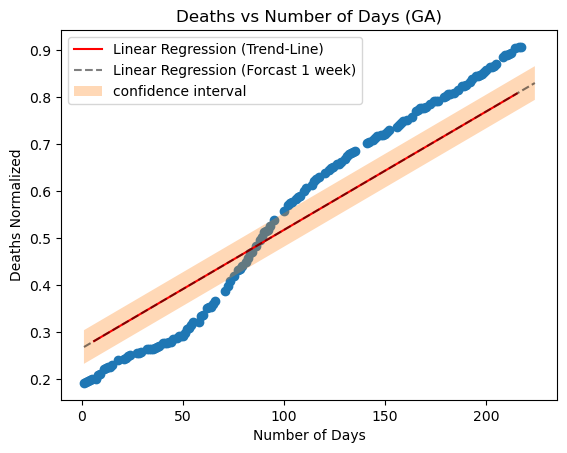

In [16]:
# this prediction is for the trend line.
ySD_pred = svr_lin_state_death.predict(xSD_test)

xS_lin_df = pd.DataFrame(xSD_test, columns=['xSD_test'])
yS_lin_df = pd.DataFrame(ySD_pred, columns=['ySD_pred'])

# ploting the confidence interval
lin_state_death = pd.concat([xS_lin_df, yS_lin_df], axis=1)
lin_state_death = lin_state_death.sort_values(by=['ySD_pred'], ascending=True)

# this is for the future forcast
xS_pred_death = np.array(test_SD.Num_of_Days).reshape(-1, 1)
yS1_pred_death = svr_lin_state_death.predict(xS_pred_death)

xSD_pre_df = pd.DataFrame(xS_pred_death, columns=['xSD_pred'])
ySD_pre_df = pd.DataFrame(yS1_pred_death, columns=['ySD_pred'])

# used for the confidence interval
pred_state_death = pd.concat([xSD_pre_df, ySD_pre_df], axis=1)
pred_state_death = pred_state_death.sort_values(by=['ySD_pred'], ascending=True)

# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yS1_pred_death)/np.sqrt(len(xS_pred_death)))

# ploting the data from GA deaths
plt.scatter(xSD_train, ySD_train)
# trend line of the data.
plt.plot(lin_state_death.xSD_test, lin_state_death.ySD_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_state_death.xSD_pred, pred_state_death.ySD_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_state_death.xSD_pred, (pred_state_death.ySD_pred-ci), (pred_state_death.ySD_pred+ci), alpha=.3, label="confidence interval")

plt.title('Deaths vs Number of Days (GA)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')
plt.legend()
plt.show()

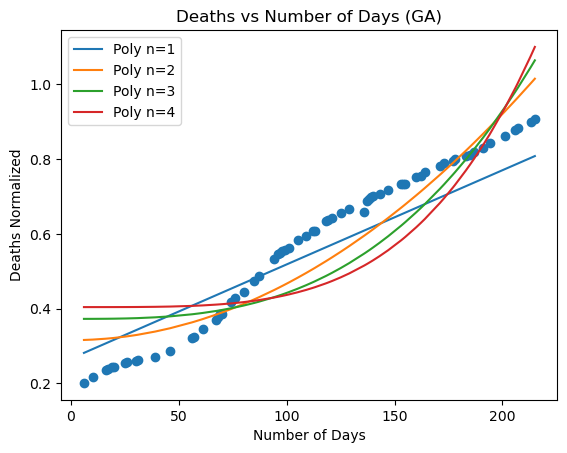

In [17]:
#make our pridict variables
yS_death_predN1 = svr_poly1_state_death.predict(xSD_test)
yS_death_predN2 = svr_poly2_state_death.predict(xSD_test)
yS_death_predN3 = svr_poly3_state_death.predict(xSD_test)
yS_death_predN4 = svr_poly4_state_death.predict(xSD_test)

# predict arrays values to dataframes.
xS_test_death_df = pd.DataFrame(xSD_test, columns=['x_test'])
yS_predN1_death_df = pd.DataFrame(yS_death_predN1, columns=['y_predN1'])
yS_predN2_death_df = pd.DataFrame(yS_death_predN2, columns=['y_predN2'])
yS_predN3_death_df = pd.DataFrame(yS_death_predN3, columns=['y_predN3'])
yS_predN4_death_df = pd.DataFrame(yS_death_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_state_death = pd.concat([xS_test_death_df, yS_predN1_death_df], axis=1)
poly2_state_death = pd.concat([xS_test_death_df, yS_predN2_death_df], axis=1)
poly3_state_death = pd.concat([xS_test_death_df, yS_predN3_death_df], axis=1)
poly4_state_death = pd.concat([xS_test_death_df, yS_predN4_death_df], axis=1)

# Sort the values by the predict values.
poly1_state_death = poly1_state_death.sort_values(by=['y_predN1'], ascending=True)
poly2_state_death = poly2_state_death.sort_values(by=['y_predN2'], ascending=True)
poly3_state_death = poly3_state_death.sort_values(by=['y_predN3'], ascending=True)
poly4_state_death = poly4_state_death.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xSD_test, ySD_test)
plt.plot(poly1_state_death.x_test, poly1_state_death.y_predN1, label="Poly n=1")
plt.plot(poly2_state_death.x_test, poly2_state_death.y_predN2, label="Poly n=2")
plt.plot(poly3_state_death.x_test, poly3_state_death.y_predN3, label="Poly n=3")
plt.plot(poly4_state_death.x_test, poly4_state_death.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Deaths vs Number of Days (GA)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
DS_mse = mean_squared_error(y_true=ySD_test, y_pred=ySD_pred, squared=True)
DS_rmse = mean_squared_error(y_true=ySD_test, y_pred=ySD_pred, squared=False)
print("- MSE:",DS_mse)
print("- RMSE:",DS_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
DSn1_mse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN1_death_df, squared=True)
DSn1_rmse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN1_death_df, squared=False)
print("- MSE:",DSn1_mse)
print("- RMSE:",DSn1_rmse)

# for n=2
print("\n- n=2")
DSn2_mse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN2_death_df, squared=True)
DSn2_rmse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN2_death_df, squared=False)
print("- MSE:",DSn2_mse)
print("- RMSE:",DSn2_rmse)

# for n=3
print("\n- n=3")
DSn3_mse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN3_death_df, squared=True)
DSn3_rmse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN3_death_df, squared=False)
print("- MSE:",DSn3_mse)
print("- RMSE:",DSn3_rmse)

# for n=4
print("\n- n=4")
DSn4_mse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN4_death_df, squared=True)
DSn4_rmse = mean_squared_error(y_true=ySD_test, y_pred=yS_predN4_death_df, squared=False)
print("- MSE:",DSn4_mse)
print("- RMSE:",DSn4_rmse)


Linear Cases Regression model:

- MSE: 0.005259924603335793
- RMSE: 0.07252533766440383

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 0.005259924240968142
- RMSE: 0.07252533516618963

- n=2
- MSE: 0.005203572191753701
- RMSE: 0.07213578995029929

- n=3
- MSE: 0.011199000823901737
- RMSE: 0.105825331673951

- n=4
- MSE: 0.016376634942869665
- RMSE: 0.12797122701165942


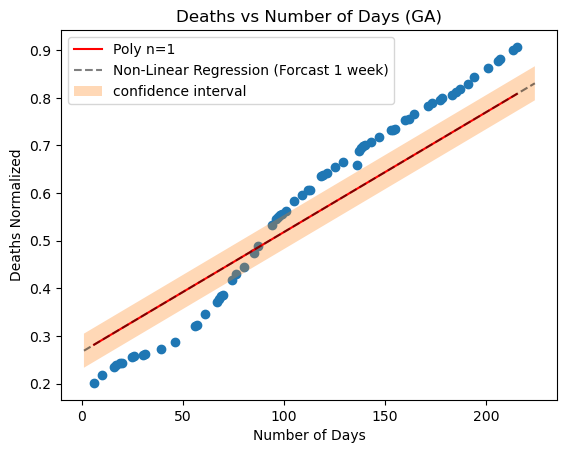

In [19]:
# this is for the future forcast
xSD_pred = np.array(test_SD.Num_of_Days).reshape(-1, 1)
ySD1_pred = svr_poly1_state_death.predict(xSD_pred)

xSD_predf = pd.DataFrame(xSD_pred, columns=['xS_pred'])
ySD_predf = pd.DataFrame(ySD1_pred, columns=['yS_pred'])

# ploting the confidence interval
pred_state_death = pd.concat([xSD_predf, ySD_predf], axis=1)
pred_state_death = pred_state_death.sort_values(by=['yS_pred'], ascending=True)

# plot our values.
plt.scatter(xSD_test, ySD_test)
plt.plot(poly1_state_death.x_test, poly1_state_death.y_predN1, label="Poly n=1", color='red')
plt.plot(pred_state_death.xS_pred, pred_state_death.yS_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
cid = 3.291 * np.std(ySD1_pred)/np.sqrt(len(xSD_pred))
plt.fill_between(pred_state_death.xS_pred, (pred_state_death.yS_pred-cid), (pred_state_death.yS_pred+cid), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Deaths vs Number of Days (GA)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

# GA - Greene County
### Regressions and Models, prediction path, RSMV and Confidence Intervals.

#### Here we start setting up our model to work with the data of Greene county, to start we set up our x and y variables.

In [20]:
# Used to set the date ranges and make our forcast line.
train_gc = df_GreeneCases_Sum[df_GreeneCases_Sum.Num_of_Days <= 217]
test_gc = df_GreeneCases_Sum

# Set our x and y values for our models for Greene County.
# x is number of days.
# y is number of new cases/deaths.
xg_cases = np.array(train_gc.Num_of_Days).reshape(-1, 1)
yg_cases = np.array(train_gc.Cases).reshape(-1, 1)

xg_train,xg_test,yg_train,yg_test=train_test_split(xg_cases, yg_cases, test_size=0.3, random_state=42)

In [21]:
# setting up our linear model.
svr_lin_greene = SVR(kernel="linear")
svr_lin_greene.fit(xg_train, yg_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_greene = SVR(kernel="poly", degree=1)
svr_poly2_greene = SVR(kernel="poly", degree=2)
svr_poly3_greene = SVR(kernel="poly", degree=3)
svr_poly4_greene = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_greene.fit(xg_train, yg_train.ravel())
svr_poly2_greene.fit(xg_train, yg_train.ravel())
svr_poly3_greene.fit(xg_train, yg_train.ravel())
svr_poly4_greene.fit(xg_train, yg_train.ravel())

SVR(degree=4, kernel='poly')

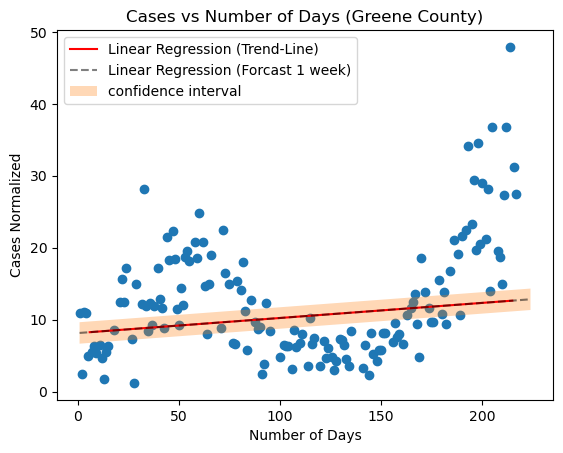

In [22]:
# this prediction is for the trend line.
yg_pred = svr_lin_greene.predict(xg_test)

xg_test_df = pd.DataFrame(xg_test, columns=['xg_test'])
yg_lin_df = pd.DataFrame(yg_pred, columns=['yg_pred'])

# ploting the confidence interval
lin_greene = pd.concat([xg_test_df, yg_lin_df], axis=1)
lin_greene = lin_greene.sort_values(by=['yg_pred'], ascending=True)

# this is for the future forcast
x_pred = np.array(test_gc.Num_of_Days).reshape(-1, 1)
yg1_pred = svr_lin_greene.predict(x_pred)

xg_predf = pd.DataFrame(x_pred, columns=['xg_pred'])
yg_predf = pd.DataFrame(yg1_pred, columns=['yg_pred'])

# used for the confidence interval
pred_greene = pd.concat([xg_predf, yg_predf], axis=1)
pred_greene = pred_greene.sort_values(by=['yg_pred'], ascending=True)
# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yg1_pred)/np.sqrt(len(x_pred))) *5

# ploting the data from GA
plt.scatter(xg_train, yg_train)
# trend line of the data.
plt.plot(lin_greene.xg_test, lin_greene.yg_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_greene.xg_pred, pred_greene.yg_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_greene.xg_pred, (pred_greene.yg_pred-ci), (pred_greene.yg_pred+ci), alpha=.3, label="confidence interval")

plt.title('Cases vs Number of Days (Greene County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')
plt.legend()
plt.show()

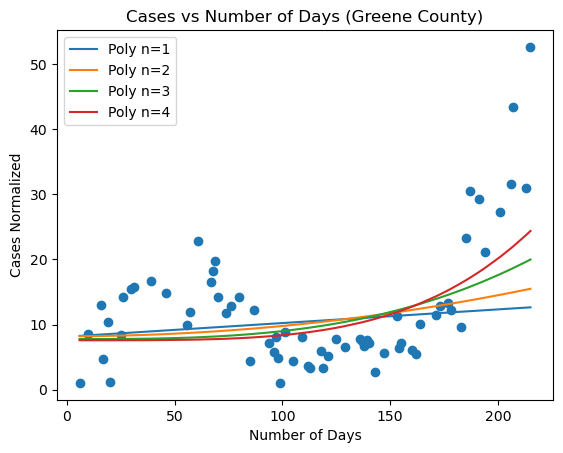

In [23]:
#make our pridict variables
yg_predN1 = svr_poly1_greene.predict(xg_test)
yg_predN2 = svr_poly2_greene.predict(xg_test)
yg_predN3 = svr_poly3_greene.predict(xg_test)
yg_predN4 = svr_poly4_greene.predict(xg_test)

# predict arrays values to dataframes.
xg_test_df = pd.DataFrame(xg_test, columns=['x_test'])
yg_predN1_df = pd.DataFrame(yg_predN1, columns=['y_predN1'])
yg_predN2_df = pd.DataFrame(yg_predN2, columns=['y_predN2'])
yg_predN3_df = pd.DataFrame(yg_predN3, columns=['y_predN3'])
yg_predN4_df = pd.DataFrame(yg_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_greene = pd.concat([xg_test_df, yg_predN1_df], axis=1)
poly2_greene = pd.concat([xg_test_df, yg_predN2_df], axis=1)
poly3_greene = pd.concat([xg_test_df, yg_predN3_df], axis=1)
poly4_greene = pd.concat([xg_test_df, yg_predN4_df], axis=1)

# Sort the values by the predict values.
poly1_greene = poly1_greene.sort_values(by=['y_predN1'], ascending=True)
poly2_greene = poly2_greene.sort_values(by=['y_predN2'], ascending=True)
poly3_greene = poly3_greene.sort_values(by=['y_predN3'], ascending=True)
poly4_greene = poly4_greene.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xg_test, yg_test)
plt.plot(poly1_greene.x_test, poly1_greene.y_predN1, label="Poly n=1")
plt.plot(poly2_greene.x_test, poly2_greene.y_predN2, label="Poly n=2")
plt.plot(poly3_greene.x_test, poly3_greene.y_predN3, label="Poly n=3")
plt.plot(poly4_greene.x_test, poly4_greene.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Cases vs Number of Days (Greene County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
cg_mse = mean_squared_error(y_true=yg_test, y_pred=yg_pred, squared=True)
cg_rmse = mean_squared_error(y_true=yg_test, y_pred=yg_pred, squared=False)
print("- MSE:",cg_mse)
print("- RMSE:",cg_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
cgn1_mse = mean_squared_error(y_true=yg_test, y_pred=yg_predN1_df, squared=True)
cgn1_rmse = mean_squared_error(y_true=yg_test, y_pred=yg_predN1_df, squared=False)
print("- MSE:",cgn1_mse)
print("- RMSE:",cgn1_rmse)

# for n=2
print("\n- n=2")
cgn2_mse = mean_squared_error(y_true=yg_test, y_pred=yg_predN2_df, squared=True)
cgn2_rmse = mean_squared_error(y_true=yg_test, y_pred=yg_predN2_df, squared=False)
print("- MSE:",cgn2_mse)
print("- RMSE:",cgn2_rmse)

# for n=3
print("\n- n=3")
cgn3_mse = mean_squared_error(y_true=yg_test, y_pred=yg_predN3_df, squared=True)
cgn3_rmse = mean_squared_error(y_true=yg_test, y_pred=yg_predN3_df, squared=False)
print("- MSE:",cgn3_mse)
print("- RMSE:",cgn3_rmse)

# for n=4
print("\n- n=4")
cgn4_mse = mean_squared_error(y_true=yg_test, y_pred=yg_predN4_df, squared=True)
cgn4_rmse = mean_squared_error(y_true=yg_test, y_pred=yg_predN4_df, squared=False)
print("- MSE:",cgn4_mse)
print("- RMSE:",cgn4_rmse)


Linear Cases Regression model:

- MSE: 89.35344629467814
- RMSE: 9.452695186806677

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 89.35343408698844
- RMSE: 9.452694541081312

- n=2
- MSE: 79.1102705016006
- RMSE: 8.894395454532061

- n=3
- MSE: 65.45665345695103
- RMSE: 8.090528626545426

- n=4
- MSE: 54.32855232327514
- RMSE: 7.3707904815748995


#### Using the RMSE values here we know that the n=4 line is the best fit for our data, since it is the lowest of the bunch. 

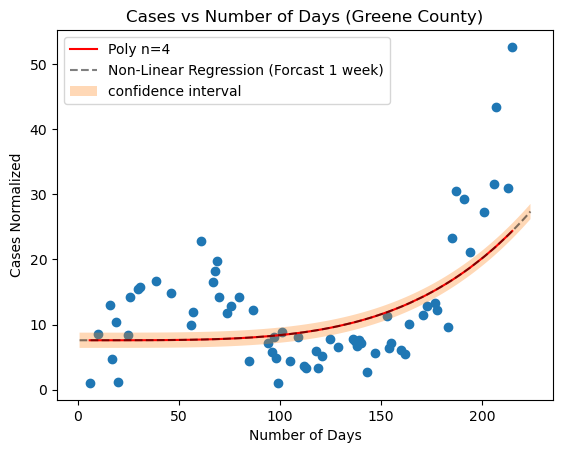

In [25]:
# this is for the future forcast
x_pred = np.array(test_gc.Num_of_Days).reshape(-1, 1)
yg1_pred = svr_poly4_greene.predict(x_pred)

xg_predf = pd.DataFrame(x_pred, columns=['xg_pred'])
yg_predf = pd.DataFrame(yg1_pred, columns=['yg_pred'])

# ploting the confidence interval
pred_greene = pd.concat([xg_predf, yg_predf], axis=1)
pred_greene = pred_greene.sort_values(by=['yg_pred'], ascending=True)

# plot our values.
plt.scatter(xg_test, yg_test)
plt.plot(poly4_greene.x_test, poly4_greene.y_predN4, label="Poly n=4", color='red')
plt.plot(pred_greene.xg_pred, pred_greene.yg_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
ci = 3.291 * np.std(yg1_pred)/np.sqrt(len(x_pred))
plt.fill_between(pred_greene.xg_pred, (pred_greene.yg_pred-ci), (pred_greene.yg_pred+ci), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Cases vs Number of Days (Greene County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Repeat process for deaths in Greene County

In [26]:
# Used to set the date ranges and make our forcast line.
train_gd = df_GreeneDeath_Sum[df_GreeneDeath_Sum.Num_of_Days <= 217]
test_gd = df_GreeneDeath_Sum

# Set our x and y values for our models for Greene County.
# x is number of days.
# y is number of new cases/deaths.
xg_death = np.array(train_gd.Num_of_Days).reshape(-1, 1)
yg_death = np.array(train_gd.Deaths).reshape(-1, 1)

xgd_train,xgd_test,ygd_train,ygd_test=train_test_split(xg_death, yg_death, test_size=0.3, random_state=42)

In [27]:
# setting up our linear model.
svr_lin_greene_death = SVR(kernel="linear")
svr_lin_greene_death.fit(xgd_train, ygd_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_greene_death = SVR(kernel="poly", degree=1)
svr_poly2_greene_death = SVR(kernel="poly", degree=2)
svr_poly3_greene_death = SVR(kernel="poly", degree=3)
svr_poly4_greene_death = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_greene_death.fit(xgd_train, ygd_train.ravel())
svr_poly2_greene_death.fit(xgd_train, ygd_train.ravel())
svr_poly3_greene_death.fit(xgd_train, ygd_train.ravel())
svr_poly4_greene_death.fit(xgd_train, ygd_train.ravel())

#plt.plot(df_GreeneDeath_Sum.Num_of_Days, df_GreeneDeath_Sum.Deaths)

SVR(degree=4, kernel='poly')

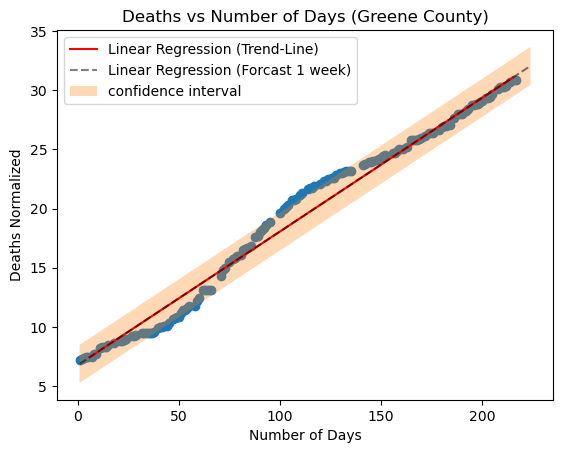

In [28]:
# this prediction is for the trend line.
ygd_pred = svr_lin_greene_death.predict(xgd_test)

xg_lin_df = pd.DataFrame(xgd_test, columns=['xg_test'])
yg_lin_df = pd.DataFrame(ygd_pred, columns=['yg_pred'])

# ploting the confidence interval
lin_greene_death = pd.concat([xg_lin_df, yg_lin_df], axis=1)
lin_greene_death = lin_greene_death.sort_values(by=['yg_pred'], ascending=True)

# this is for the future forcast
x_pred_death = np.array(test_gd.Num_of_Days).reshape(-1, 1)
yg1_pred_death = svr_lin_greene_death.predict(x_pred_death)

xgd_pre_df = pd.DataFrame(x_pred_death, columns=['xg_pred'])
ygd_pre_df = pd.DataFrame(yg1_pred_death, columns=['yg_pred'])

# used for the confidence interval
pred_greene_death = pd.concat([xgd_pre_df, ygd_pre_df], axis=1)
pred_greene_death = pred_greene_death.sort_values(by=['yg_pred'], ascending=True)

# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yg1_pred_death)/np.sqrt(len(x_pred_death)))

# ploting the data from Greene County deaths
plt.scatter(xgd_train, ygd_train)
# trend line of the data.
plt.plot(lin_greene_death.xg_test, lin_greene_death.yg_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_greene_death.xg_pred, pred_greene_death.yg_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_greene_death.xg_pred, (pred_greene_death.yg_pred-ci), (pred_greene_death.yg_pred+ci), alpha=.3, label="confidence interval")

plt.title('Deaths vs Number of Days (Greene County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')
plt.legend()
plt.show()

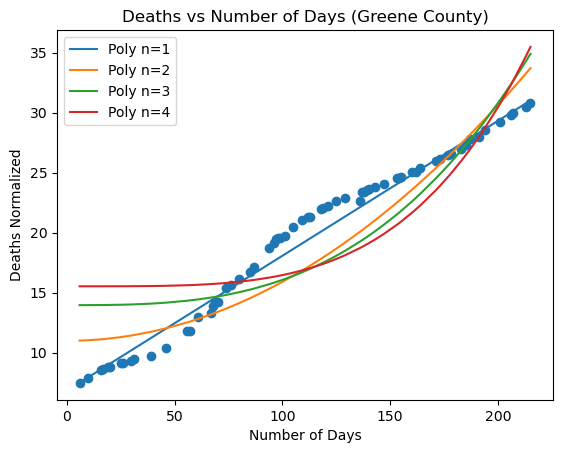

In [29]:
#make our pridict variables
yg_death_predN1 = svr_poly1_greene_death.predict(xgd_test)
yg_death_predN2 = svr_poly2_greene_death.predict(xgd_test)
yg_death_predN3 = svr_poly3_greene_death.predict(xgd_test)
yg_death_predN4 = svr_poly4_greene_death.predict(xgd_test)

# predict arrays values to dataframes.
xg_test_death_df = pd.DataFrame(xgd_test, columns=['x_test'])
yg_predN1_death_df = pd.DataFrame(yg_death_predN1, columns=['y_predN1'])
yg_predN2_death_df = pd.DataFrame(yg_death_predN2, columns=['y_predN2'])
yg_predN3_death_df = pd.DataFrame(yg_death_predN3, columns=['y_predN3'])
yg_predN4_death_df = pd.DataFrame(yg_death_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_greene_death = pd.concat([xg_test_death_df, yg_predN1_death_df], axis=1)
poly2_greene_death = pd.concat([xg_test_death_df, yg_predN2_death_df], axis=1)
poly3_greene_death = pd.concat([xg_test_death_df, yg_predN3_death_df], axis=1)
poly4_greene_death = pd.concat([xg_test_death_df, yg_predN4_death_df], axis=1)

# Sort the values by the predict values.
poly1_greene_death = poly1_greene_death.sort_values(by=['y_predN1'], ascending=True)
poly2_greene_death = poly2_greene_death.sort_values(by=['y_predN2'], ascending=True)
poly3_greene_death = poly3_greene_death.sort_values(by=['y_predN3'], ascending=True)
poly4_greene_death = poly4_greene_death.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xgd_test, ygd_test)
plt.plot(poly1_greene_death.x_test, poly1_greene_death.y_predN1, label="Poly n=1")
plt.plot(poly2_greene_death.x_test, poly2_greene_death.y_predN2, label="Poly n=2")
plt.plot(poly3_greene_death.x_test, poly3_greene_death.y_predN3, label="Poly n=3")
plt.plot(poly4_greene_death.x_test, poly4_greene_death.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Deaths vs Number of Days (Greene County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
dg_mse = mean_squared_error(y_true=ygd_test, y_pred=ygd_pred, squared=True)
dg_rmse = mean_squared_error(y_true=ygd_test, y_pred=ygd_pred, squared=False)
print("- MSE:",dg_mse)
print("- RMSE:",dg_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
dgn1_mse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN1_death_df, squared=True)
dgn1_rmse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN1_death_df, squared=False)
print("- MSE:",dgn1_mse)
print("- RMSE:",dgn1_rmse)

# for n=2
print("\n- n=2")
dgn2_mse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN2_death_df, squared=True)
dgn2_rmse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN2_death_df, squared=False)
print("- MSE:",dgn2_mse)
print("- RMSE:",dgn2_rmse)

# for n=3
print("\n- n=3")
dgn3_mse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN3_death_df, squared=True)
dgn3_rmse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN3_death_df, squared=False)
print("- MSE:",dgn3_mse)
print("- RMSE:",dgn3_rmse)

# for n=4
print("\n- n=4")
dgn4_mse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN4_death_df, squared=True)
dgn4_rmse = mean_squared_error(y_true=ygd_test, y_pred=yg_predN4_death_df, squared=False)
print("- MSE:",dgn4_mse)
print("- RMSE:",dgn4_rmse)


Linear Cases Regression model:

- MSE: 1.0016706591869151
- RMSE: 1.000834980996825

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 0.9973752639158069
- RMSE: 0.9986867696709549

- n=2
- MSE: 6.495186032295656
- RMSE: 2.5485654851888064

- n=3
- MSE: 11.791341383350188
- RMSE: 3.4338522658015136

- n=4
- MSE: 16.607994315018008
- RMSE: 4.075290703130024


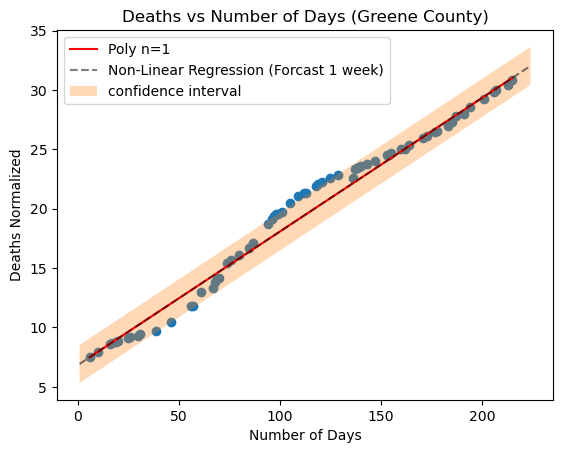

In [31]:
# this is for the future forcast
xd_pred = np.array(test_gd.Num_of_Days).reshape(-1, 1)
ygd1_pred = svr_poly1_greene_death.predict(xd_pred)

xgd_predf = pd.DataFrame(xd_pred, columns=['xg_pred'])
ygd_predf = pd.DataFrame(ygd1_pred, columns=['yg_pred'])

# ploting the confidence interval
pred_greene_death = pd.concat([xgd_predf, ygd_predf], axis=1)
pred_greene_death = pred_greene_death.sort_values(by=['yg_pred'], ascending=True)

# plot our values.
plt.scatter(xgd_test, ygd_test)
plt.plot(poly1_greene_death.x_test, poly1_greene_death.y_predN1, label="Poly n=1", color='red')
plt.plot(pred_greene_death.xg_pred, pred_greene_death.yg_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
cid = 3.291 * np.std(ygd1_pred)/np.sqrt(len(xd_pred))
plt.fill_between(pred_greene_death.xg_pred, (pred_greene_death.yg_pred-cid), (pred_greene_death.yg_pred+cid), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Deaths vs Number of Days (Greene County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

# GA - Franklin County
### Regressions and Models, prediction path, RSMV and Confidence Intervals.

#### Here we start setting up our model to work with the data of Franklin County, to start we set up our x and y variables.

In [32]:
# Used to set the date ranges and make our forcast line.
train_FC = df_FrankCases_Sum[df_FrankCases_Sum.Num_of_Days <= 217]
test_FC = df_FrankCases_Sum

# Set our x and y values for our models for Franklin County.
# x is number of days.
# y is number of new cases
x_FC_cases = np.array(train_FC.Num_of_Days).reshape(-1, 1)
y_FC_cases = np.array(train_FC.Cases).reshape(-1, 1)

xFC_train,xFC_test,yFC_train,yFC_test=train_test_split(x_FC_cases, y_FC_cases, test_size=0.3, random_state=42)

In [33]:
# setting up our linear model.
svr_lin_frank = SVR(kernel="linear")
svr_lin_frank.fit(xFC_train, yFC_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_frank = SVR(kernel="poly", degree=1)
svr_poly2_frank = SVR(kernel="poly", degree=2)
svr_poly3_frank = SVR(kernel="poly", degree=3)
svr_poly4_frank = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_frank.fit(xFC_train, yFC_train.ravel())
svr_poly2_frank.fit(xFC_train, yFC_train.ravel())
svr_poly3_frank.fit(xFC_train, yFC_train.ravel())
svr_poly4_frank.fit(xFC_train, yFC_train.ravel())

SVR(degree=4, kernel='poly')

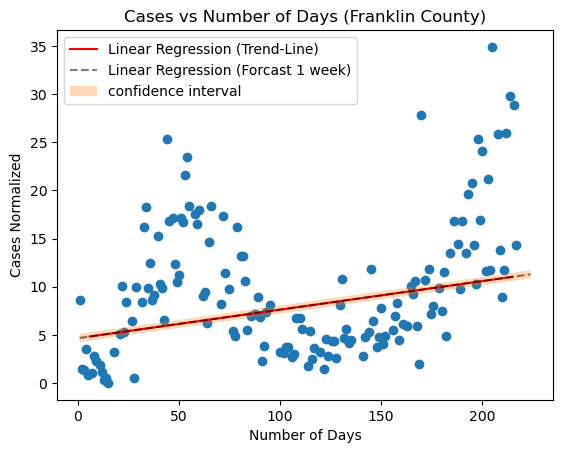

In [34]:
# this prediction is for the trend line.
yFC_pred = svr_lin_frank.predict(xFC_test)

xFC_test_df = pd.DataFrame(xFC_test, columns=['xFC_test'])
yFC_lin_df = pd.DataFrame(yFC_pred, columns=['yFC_pred'])

# ploting the confidence interval
lin_frank = pd.concat([xFC_test_df, yFC_lin_df], axis=1)
lin_frank = lin_frank.sort_values(by=['yFC_pred'], ascending=True)

# this is for the future forcast
xFC_pred = np.array(test_FC.Num_of_Days).reshape(-1, 1)
yFC1_pred = svr_lin_frank.predict(xFC_pred)

xFC_pred_df = pd.DataFrame(xFC_pred, columns=['xF_pred'])
yFC_pred_df = pd.DataFrame(yFC1_pred, columns=['yF_pred'])

# used for the confidence interval
pred_frank = pd.concat([xFC_pred_df, yFC_pred_df], axis=1)
pred_frank = pred_frank.sort_values(by=['yF_pred'], ascending=True)
# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yFC1_pred)/np.sqrt(len(xFC_pred))) #*5

# ploting the data from Franklin County
plt.scatter(xFC_train, yFC_train)
# trend line of the data.
plt.plot(lin_frank.xFC_test, lin_frank.yFC_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_frank.xF_pred, pred_frank.yF_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_frank.xF_pred, (pred_frank.yF_pred-ci), (pred_frank.yF_pred+ci), alpha=.3, label="confidence interval")

plt.title('Cases vs Number of Days (Franklin County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')
plt.legend()
plt.show()

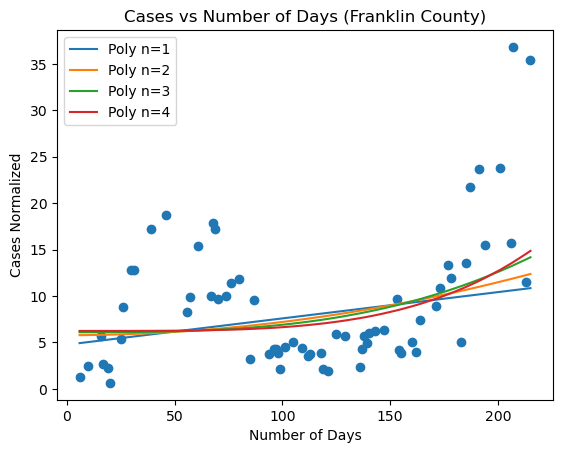

In [35]:
#make our pridict variables
yFC_predN1 = svr_poly1_frank.predict(xFC_test)
yFC_predN2 = svr_poly2_frank.predict(xFC_test)
yFC_predN3 = svr_poly3_frank.predict(xFC_test)
yFC_predN4 = svr_poly4_frank.predict(xFC_test)

# predict arrays values to dataframes.
xFC_test_df = pd.DataFrame(xFC_test, columns=['x_test'])
yFC_predN1_df = pd.DataFrame(yFC_predN1, columns=['y_predN1'])
yFC_predN2_df = pd.DataFrame(yFC_predN2, columns=['y_predN2'])
yFC_predN3_df = pd.DataFrame(yFC_predN3, columns=['y_predN3'])
yFC_predN4_df = pd.DataFrame(yFC_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_frank = pd.concat([xFC_test_df, yFC_predN1_df], axis=1)
poly2_frank = pd.concat([xFC_test_df, yFC_predN2_df], axis=1)
poly3_frank = pd.concat([xFC_test_df, yFC_predN3_df], axis=1)
poly4_frank = pd.concat([xFC_test_df, yFC_predN4_df], axis=1)

# Sort the values by the predict values.
poly1_frank = poly1_frank.sort_values(by=['y_predN1'], ascending=True)
poly2_frank = poly2_frank.sort_values(by=['y_predN2'], ascending=True)
poly3_frank = poly3_frank.sort_values(by=['y_predN3'], ascending=True)
poly4_frank = poly4_frank.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xFC_test, yFC_test)
plt.plot(poly1_frank.x_test, poly1_frank.y_predN1, label="Poly n=1")
plt.plot(poly2_frank.x_test, poly2_frank.y_predN2, label="Poly n=2")
plt.plot(poly3_frank.x_test, poly3_frank.y_predN3, label="Poly n=3")
plt.plot(poly4_frank.x_test, poly4_frank.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Cases vs Number of Days (Franklin County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
CF_mse = mean_squared_error(y_true=yFC_test, y_pred=yFC_pred, squared=True)
CF_rmse = mean_squared_error(y_true=yFC_test, y_pred=yFC_pred, squared=False)
print("- MSE:",CF_mse)
print("- RMSE:",CF_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
CFn1_mse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN1_df, squared=True)
CFn1_rmse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN1_df, squared=False)
print("- MSE:",CFn1_mse)
print("- RMSE:",CFn1_rmse)

# for n=2
print("\n- n=2")
CFn2_mse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN2_df, squared=True)
CFn2_rmse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN2_df, squared=False)
print("- MSE:",CFn2_mse)
print("- RMSE:",CFn2_rmse)

# for n=3
print("\n- n=3")
CFn3_mse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN3_df, squared=True)
CFn3_rmse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN3_df, squared=False)
print("- MSE:",CFn3_mse)
print("- RMSE:",CFn3_rmse)

# for n=4
print("\n- n=4")
CFn4_mse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN4_df, squared=True)
CFn4_rmse = mean_squared_error(y_true=yFC_test, y_pred=yFC_predN4_df, squared=False)
print("- MSE:",CFn4_mse)
print("- RMSE:",CFn4_rmse)


Linear Cases Regression model:

- MSE: 48.8801523343895
- RMSE: 6.991434211546977

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 49.110344999517814
- RMSE: 7.007877353344436

- n=2
- MSE: 45.57381556446736
- RMSE: 6.750838137925347

- n=3
- MSE: 41.73287660014297
- RMSE: 6.46009880730496

- n=4
- MSE: 40.069538923833925
- RMSE: 6.3300504677161875


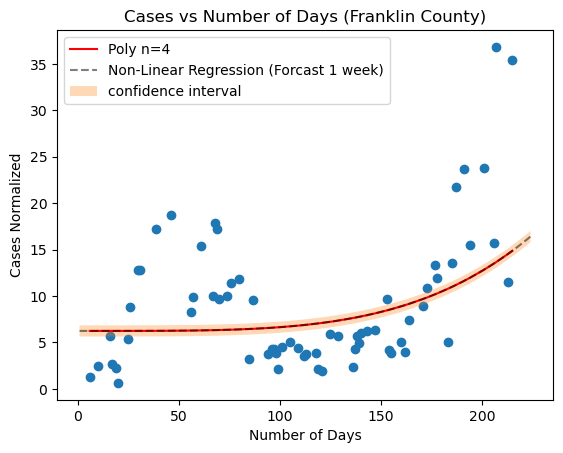

In [37]:
# this is for the future forcast
xFC_pred = np.array(test_FC.Num_of_Days).reshape(-1, 1)
yFC1_pred = svr_poly4_frank.predict(xFC_pred)

xFC_pre_df = pd.DataFrame(xFC_pred, columns=['xFC_pred'])
yFC_pre_df = pd.DataFrame(yFC1_pred, columns=['yFC_pred'])

# ploting the confidence interval
pred_frank = pd.concat([xFC_pre_df, yFC_pre_df], axis=1)
pred_frank = pred_frank.sort_values(by=['yFC_pred'], ascending=True)

# plot our values.
plt.scatter(xFC_test, yFC_test)
plt.plot(poly4_frank.x_test, poly4_frank.y_predN4, label="Poly n=4", color='red')
plt.plot(pred_frank.xFC_pred, pred_frank.yFC_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
ci = 3.291 * np.std(yFC1_pred)/np.sqrt(len(xFC_pred))
plt.fill_between(pred_frank.xFC_pred, (pred_frank.yFC_pred-ci), (pred_frank.yFC_pred+ci), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Cases vs Number of Days (Franklin County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Repeat process for deaths in Franklin County

In [38]:
# Used to set the date ranges and make our forcast line.
train_FD = df_FrankDeath_Sum[df_FrankDeath_Sum.Num_of_Days <= 217]
test_FD = df_FrankDeath_Sum

# Set our x and y values for our models for Franklin County.
# x is number of days.
# y is number of new deaths.
xF_death = np.array(train_FD.Num_of_Days).reshape(-1, 1)
yF_death = np.array(train_FD.Deaths).reshape(-1, 1)

xFD_train,xFD_test,yFD_train,yFD_test=train_test_split(xF_death, yF_death, test_size=0.3, random_state=42)

In [39]:
# setting up our linear model.
svr_lin_frank_death = SVR(kernel="linear")
svr_lin_frank_death.fit(xFD_train, yFD_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_frank_death = SVR(kernel="poly", degree=1)
svr_poly2_frank_death = SVR(kernel="poly", degree=2)
svr_poly3_frank_death = SVR(kernel="poly", degree=3)
svr_poly4_frank_death = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_frank_death.fit(xFD_train, yFD_train.ravel())
svr_poly2_frank_death.fit(xFD_train, yFD_train.ravel())
svr_poly3_frank_death.fit(xFD_train, yFD_train.ravel())
svr_poly4_frank_death.fit(xFD_train, yFD_train.ravel())

SVR(degree=4, kernel='poly')

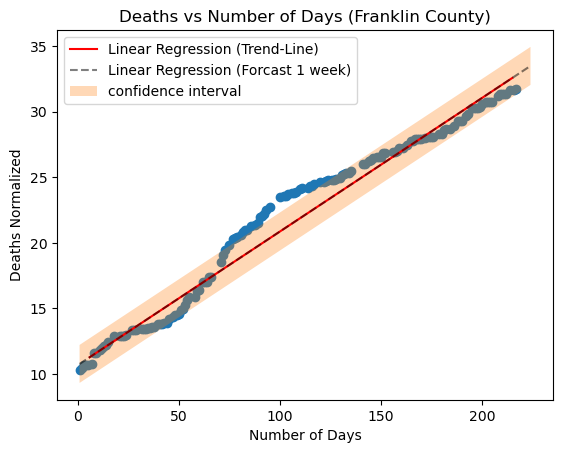

In [40]:
# this prediction is for the trend line.
yFD_pred = svr_lin_frank_death.predict(xFD_test)

xF_lin_df = pd.DataFrame(xFD_test, columns=['xFD_test'])
yF_lin_df = pd.DataFrame(yFD_pred, columns=['yFD_pred'])

# ploting the confidence interval
lin_frank_death = pd.concat([xF_lin_df, yF_lin_df], axis=1)
lin_frank_death = lin_frank_death.sort_values(by=['yFD_pred'], ascending=True)

# this is for the future forcast
xF_pred_death = np.array(test_FD.Num_of_Days).reshape(-1, 1)
yF1_pred_death = svr_lin_frank_death.predict(xF_pred_death)

xFD_pre_df = pd.DataFrame(xF_pred_death, columns=['xFD_pred'])
yFD_pre_df = pd.DataFrame(yF1_pred_death, columns=['yFD_pred'])

# used for the confidence interval
pred_frank_death = pd.concat([xFD_pre_df, yFD_pre_df], axis=1)
pred_frank_death = pred_frank_death.sort_values(by=['yFD_pred'], ascending=True)

# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yF1_pred_death)/np.sqrt(len(xF_pred_death)))

# ploting the data from Franklin County deaths
plt.scatter(xFD_train, yFD_train)
# trend line of the data.
plt.plot(lin_frank_death.xFD_test, lin_frank_death.yFD_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_frank_death.xFD_pred, pred_frank_death.yFD_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_frank_death.xFD_pred, (pred_frank_death.yFD_pred-ci), (pred_frank_death.yFD_pred+ci), alpha=.3, label="confidence interval")

plt.title('Deaths vs Number of Days (Franklin County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')
plt.legend()
plt.show()

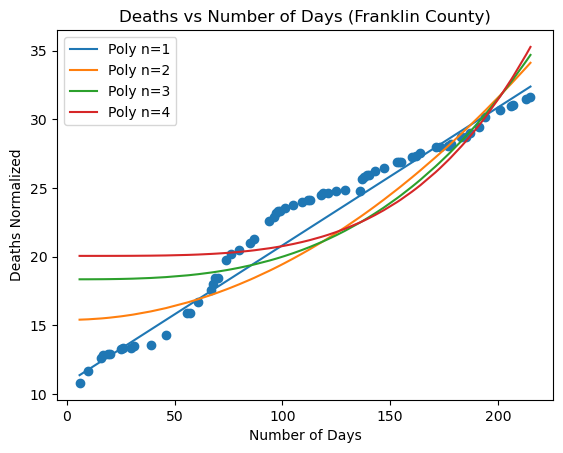

In [41]:
#make our pridict variables
yF_death_predN1 = svr_poly1_frank_death.predict(xFD_test)
yF_death_predN2 = svr_poly2_frank_death.predict(xFD_test)
yF_death_predN3 = svr_poly3_frank_death.predict(xFD_test)
yF_death_predN4 = svr_poly4_frank_death.predict(xFD_test)

# predict arrays values to dataframes.
xF_test_death_df = pd.DataFrame(xFD_test, columns=['x_test'])
yF_predN1_death_df = pd.DataFrame(yF_death_predN1, columns=['y_predN1'])
yF_predN2_death_df = pd.DataFrame(yF_death_predN2, columns=['y_predN2'])
yF_predN3_death_df = pd.DataFrame(yF_death_predN3, columns=['y_predN3'])
yF_predN4_death_df = pd.DataFrame(yF_death_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_frank_death = pd.concat([xF_test_death_df, yF_predN1_death_df], axis=1)
poly2_frank_death = pd.concat([xF_test_death_df, yF_predN2_death_df], axis=1)
poly3_frank_death = pd.concat([xF_test_death_df, yF_predN3_death_df], axis=1)
poly4_frank_death = pd.concat([xF_test_death_df, yF_predN4_death_df], axis=1)

# Sort the values by the predict values.
poly1_frank_death = poly1_frank_death.sort_values(by=['y_predN1'], ascending=True)
poly2_frank_death = poly2_frank_death.sort_values(by=['y_predN2'], ascending=True)
poly3_frank_death = poly3_frank_death.sort_values(by=['y_predN3'], ascending=True)
poly4_frank_death = poly4_frank_death.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xFD_test, yFD_test)
plt.plot(poly1_frank_death.x_test, poly1_frank_death.y_predN1, label="Poly n=1")
plt.plot(poly2_frank_death.x_test, poly2_frank_death.y_predN2, label="Poly n=2")
plt.plot(poly3_frank_death.x_test, poly3_frank_death.y_predN3, label="Poly n=3")
plt.plot(poly4_frank_death.x_test, poly4_frank_death.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Deaths vs Number of Days (Franklin County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
DF_mse = mean_squared_error(y_true=yFD_test, y_pred=yFD_pred, squared=True)
DF_rmse = mean_squared_error(y_true=yFD_test, y_pred=yFD_pred, squared=False)
print("- MSE:",DF_mse)
print("- RMSE:",DF_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
DFn1_mse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN1_death_df, squared=True)
DFn1_rmse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN1_death_df, squared=False)
print("- MSE:",DFn1_mse)
print("- RMSE:",DFn1_rmse)

# for n=2
print("\n- n=2")
DFn2_mse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN2_death_df, squared=True)
DFn2_rmse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN2_death_df, squared=False)
print("- MSE:",DFn2_mse)
print("- RMSE:",DFn2_rmse)

# for n=3
print("\n- n=3")
DFn3_mse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN3_death_df, squared=True)
DFn3_rmse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN3_death_df, squared=False)
print("- MSE:",DFn3_mse)
print("- RMSE:",DFn3_rmse)

# for n=4
print("\n- n=4")
DFn4_mse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN4_death_df, squared=True)
DFn4_rmse = mean_squared_error(y_true=yFD_test, y_pred=yF_predN4_death_df, squared=False)
print("- MSE:",DFn4_mse)
print("- RMSE:",DFn4_rmse)


Linear Cases Regression model:

- MSE: 1.553377113533512
- RMSE: 1.2463455032748791

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 1.5952523469205833
- RMSE: 1.2630329951828587

- n=2
- MSE: 6.270684105360141
- RMSE: 2.5041334040661933

- n=3
- MSE: 10.46090796083356
- RMSE: 3.234332691736204

- n=4
- MSE: 14.441473550837417
- RMSE: 3.800193883321931


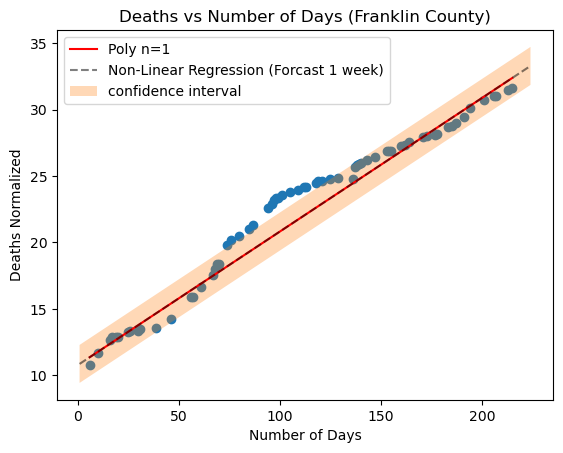

In [43]:
# this is for the future forcast
xFD_pred = np.array(test_FD.Num_of_Days).reshape(-1, 1)
yFD1_pred = svr_poly1_frank_death.predict(xFD_pred)

xFD_predf = pd.DataFrame(xFD_pred, columns=['xF_pred'])
yFD_predf = pd.DataFrame(yFD1_pred, columns=['yF_pred'])

# ploting the confidence interval
pred_frank_death = pd.concat([xFD_predf, yFD_predf], axis=1)
pred_frank_death = pred_frank_death.sort_values(by=['yF_pred'], ascending=True)

# plot our values.
plt.scatter(xFD_test, yFD_test)
plt.plot(poly1_frank_death.x_test, poly1_frank_death.y_predN1, label="Poly n=1", color='red')
plt.plot(pred_frank_death.xF_pred, pred_frank_death.yF_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
cid = 3.291 * np.std(yFD1_pred)/np.sqrt(len(xFD_pred))
plt.fill_between(pred_frank_death.xF_pred, (pred_frank_death.yF_pred-cid), (pred_frank_death.yF_pred+cid), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Deaths vs Number of Days (Franklin County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

# GA - Clinch County
### Regressions and Models, prediction path, RSMV and Confidence Intervals.

#### Here we start setting up our model to work with the data of Clinch County, to start we set up our x and y variables.

In [44]:
# Used to set the date ranges and make our forcast line.
train_CC = df_ClinchCases_Sum[df_ClinchCases_Sum.Num_of_Days <= 217]
test_CC = df_ClinchCases_Sum

# Set our x and y values for our models for Franklin County.
# x is number of days.
# y is number of new cases
x_CC_cases = np.array(train_CC.Num_of_Days).reshape(-1, 1)
y_CC_cases = np.array(train_CC.Cases).reshape(-1, 1)

xCC_train,xCC_test,yCC_train,yCC_test=train_test_split(x_CC_cases, y_CC_cases, test_size=0.3, random_state=42)

In [45]:
# setting up our linear model.
svr_lin_clinch = SVR(kernel="linear")
svr_lin_clinch.fit(xFC_train, yFC_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_clinch = SVR(kernel="poly", degree=1)
svr_poly2_clinch = SVR(kernel="poly", degree=2)
svr_poly3_clinch = SVR(kernel="poly", degree=3)
svr_poly4_clinch = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_clinch.fit(xCC_train, yCC_train.ravel())
svr_poly2_clinch.fit(xCC_train, yCC_train.ravel())
svr_poly3_clinch.fit(xCC_train, yCC_train.ravel())
svr_poly4_clinch.fit(xCC_train, yCC_train.ravel())

SVR(degree=4, kernel='poly')

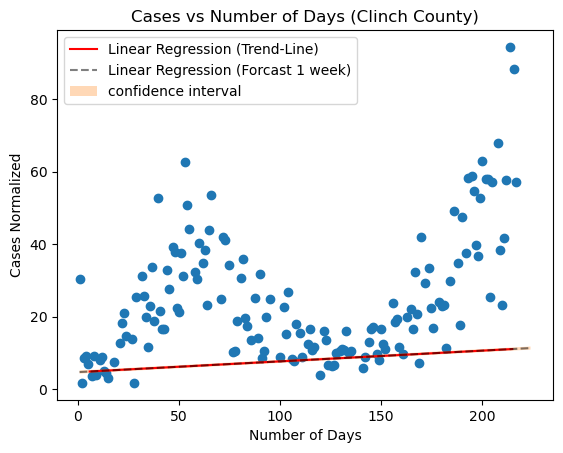

In [46]:
# this prediction is for the trend line.
yCC_pred = svr_lin_clinch.predict(xCC_test)

xCC_test_df = pd.DataFrame(xCC_test, columns=['xCC_test'])
yCC_lin_df = pd.DataFrame(yCC_pred, columns=['yCC_pred'])

# ploting the confidence interval
lin_clinch = pd.concat([xCC_test_df, yCC_lin_df], axis=1)
lin_clinch = lin_clinch.sort_values(by=['yCC_pred'], ascending=True)

# this is for the future forcast
xCC_pred = np.array(test_CC.Num_of_Days).reshape(-1, 1)
yCC1_pred = svr_lin_clinch.predict(xCC_pred)

xCC_pred_df = pd.DataFrame(xCC_pred, columns=['xC_pred'])
yCC_pred_df = pd.DataFrame(yCC1_pred, columns=['yC_pred'])

# used for the confidence interval
pred_clinch = pd.concat([xCC_pred_df, yCC_pred_df], axis=1)
pred_clinch = pred_clinch.sort_values(by=['yC_pred'], ascending=True)
# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yCC1_pred)/np.sqrt(len(xCC_pred))) 

# ploting the data from Clinch County
plt.scatter(xCC_train, yCC_train)
# trend line of the data.
plt.plot(lin_clinch.xCC_test, lin_clinch.yCC_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_clinch.xC_pred, pred_clinch.yC_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_clinch.xC_pred, (pred_clinch.yC_pred-ci), (pred_clinch.yC_pred+ci), alpha=.3, label="confidence interval")

plt.title('Cases vs Number of Days (Clinch County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')
plt.legend()
plt.show()

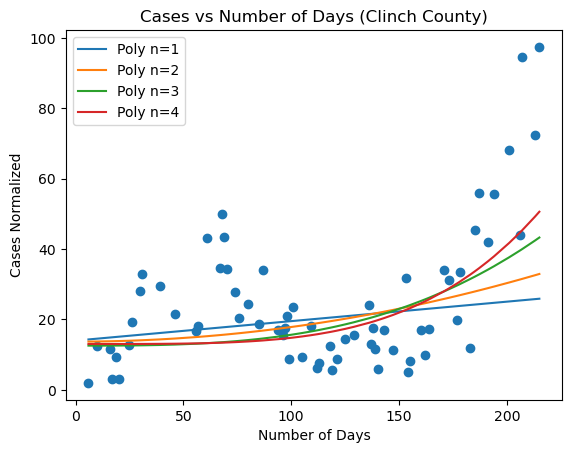

In [47]:
#make our pridict variables
yCC_predN1 = svr_poly1_clinch.predict(xCC_test)
yCC_predN2 = svr_poly2_clinch.predict(xCC_test)
yCC_predN3 = svr_poly3_clinch.predict(xCC_test)
yCC_predN4 = svr_poly4_clinch.predict(xCC_test)

# predict arrays values to dataframes.
xCC_test_df = pd.DataFrame(xCC_test, columns=['x_test'])
yCC_predN1_df = pd.DataFrame(yCC_predN1, columns=['y_predN1'])
yCC_predN2_df = pd.DataFrame(yCC_predN2, columns=['y_predN2'])
yCC_predN3_df = pd.DataFrame(yCC_predN3, columns=['y_predN3'])
yCC_predN4_df = pd.DataFrame(yCC_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_clinch = pd.concat([xCC_test_df, yCC_predN1_df], axis=1)
poly2_clinch = pd.concat([xCC_test_df, yCC_predN2_df], axis=1)
poly3_clinch = pd.concat([xCC_test_df, yCC_predN3_df], axis=1)
poly4_clinch = pd.concat([xCC_test_df, yCC_predN4_df], axis=1)

# Sort the values by the predict values.
poly1_clinch = poly1_clinch.sort_values(by=['y_predN1'], ascending=True)
poly2_clinch = poly2_clinch.sort_values(by=['y_predN2'], ascending=True)
poly3_clinch = poly3_clinch.sort_values(by=['y_predN3'], ascending=True)
poly4_clinch = poly4_clinch.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xCC_test, yCC_test)
plt.plot(poly1_clinch.x_test, poly1_clinch.y_predN1, label="Poly n=1")
plt.plot(poly2_clinch.x_test, poly2_clinch.y_predN2, label="Poly n=2")
plt.plot(poly3_clinch.x_test, poly3_clinch.y_predN3, label="Poly n=3")
plt.plot(poly4_clinch.x_test, poly4_clinch.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Cases vs Number of Days (Clinch County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
CC_mse = mean_squared_error(y_true=yCC_test, y_pred=yCC_pred, squared=True)
CC_rmse = mean_squared_error(y_true=yCC_test, y_pred=yCC_pred, squared=False)
print("- MSE:",CC_mse)
print("- RMSE:",CC_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
CCn1_mse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN1_df, squared=True)
CCn1_rmse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN1_df, squared=False)
print("- MSE:",CCn1_mse)
print("- RMSE:",CCn1_rmse)

# for n=2
print("\n- n=2")
CCn2_mse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN2_df, squared=True)
CCn2_rmse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN2_df, squared=False)
print("- MSE:",CCn2_mse)
print("- RMSE:",CCn2_rmse)

# for n=3
print("\n- n=3")
CCn3_mse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN3_df, squared=True)
CCn3_rmse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN3_df, squared=False)
print("- MSE:",CCn3_mse)
print("- RMSE:",CCn3_rmse)

# for n=4
print("\n- n=4")
CCn4_mse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN4_df, squared=True)
CCn4_rmse = mean_squared_error(y_true=yCC_test, y_pred=yCC_predN4_df, squared=False)
print("- MSE:",CCn4_mse)
print("- RMSE:",CCn4_rmse)


Linear Cases Regression model:

- MSE: 657.2423033908441
- RMSE: 25.63673737804489

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 369.71967274062405
- RMSE: 19.228095920829603

- n=2
- MSE: 324.3721660489547
- RMSE: 18.010334978810214

- n=3
- MSE: 271.3144510099169
- RMSE: 16.471625633492188

- n=4
- MSE: 235.89828974262764
- RMSE: 15.358980752075563


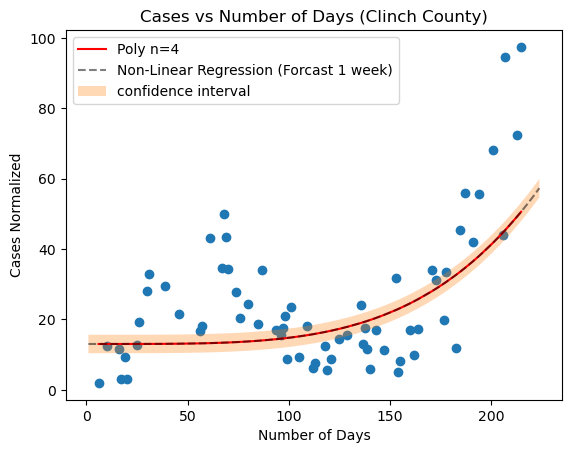

In [49]:
# this is for the future forcast
xCC_pred = np.array(test_CC.Num_of_Days).reshape(-1, 1)
yCC1_pred = svr_poly4_clinch.predict(xCC_pred)

xCC_pre_df = pd.DataFrame(xCC_pred, columns=['xCC_pred'])
yCC_pre_df = pd.DataFrame(yCC1_pred, columns=['yCC_pred'])

# ploting the confidence interval
pred_clinch = pd.concat([xCC_pre_df, yCC_pre_df], axis=1)
pred_clinch = pred_clinch.sort_values(by=['yCC_pred'], ascending=True)

# plot our values.
plt.scatter(xCC_test, yCC_test)
plt.plot(poly4_clinch.x_test, poly4_clinch.y_predN4, label="Poly n=4", color='red')
plt.plot(pred_clinch.xCC_pred, pred_clinch.yCC_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
ci = 3.291 * np.std(yCC1_pred)/np.sqrt(len(xCC_pred))
plt.fill_between(pred_clinch.xCC_pred, (pred_clinch.yCC_pred-ci), (pred_clinch.yCC_pred+ci), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Cases vs Number of Days (Clinch County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Repeat process for deaths in Clinch County


In [50]:
# Used to set the date ranges and make our forcast line.
train_CD = df_ClinchDeath_Sum[df_ClinchDeath_Sum.Num_of_Days <= 217]
test_CD = df_ClinchDeath_Sum

# Set our x and y values for our models for Franklin County.
# x is number of days.
# y is number of new deaths.
xC_death = np.array(train_CD.Num_of_Days).reshape(-1, 1)
yC_death = np.array(train_CD.Deaths).reshape(-1, 1)

xCD_train,xCD_test,yCD_train,yCD_test=train_test_split(xC_death, yC_death, test_size=0.3, random_state=42)

In [51]:
# setting up our linear model.
svr_lin_clinch_death = SVR(kernel="linear")
svr_lin_clinch_death.fit(xCD_train, yCD_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_clinch_death = SVR(kernel="poly", degree=1)
svr_poly2_clinch_death = SVR(kernel="poly", degree=2)
svr_poly3_clinch_death = SVR(kernel="poly", degree=3)
svr_poly4_clinch_death = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_clinch_death.fit(xCD_train, yCD_train.ravel())
svr_poly2_clinch_death.fit(xCD_train, yCD_train.ravel())
svr_poly3_clinch_death.fit(xCD_train, yCD_train.ravel())
svr_poly4_clinch_death.fit(xCD_train, yCD_train.ravel())

SVR(degree=4, kernel='poly')

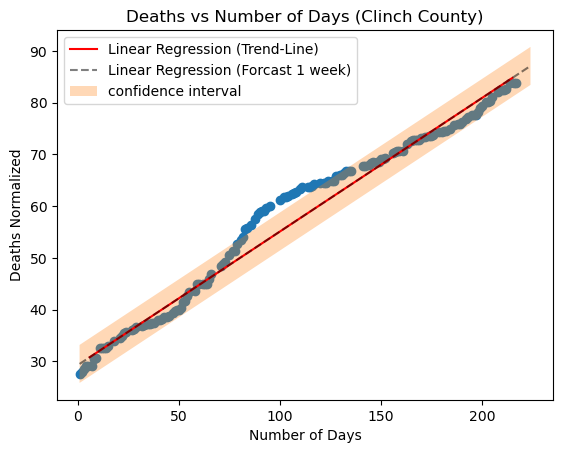

In [52]:
# this prediction is for the trend line.
yCD_pred = svr_lin_clinch_death.predict(xCD_test)

xC_lin_df = pd.DataFrame(xCD_test, columns=['xCD_test'])
yC_lin_df = pd.DataFrame(yCD_pred, columns=['yCD_pred'])

# ploting the confidence interval
lin_clinch_death = pd.concat([xC_lin_df, yC_lin_df], axis=1)
lin_clinch_death = lin_clinch_death.sort_values(by=['yCD_pred'], ascending=True)

# this is for the future forcast
xC_pred_death = np.array(test_CD.Num_of_Days).reshape(-1, 1)
yC1_pred_death = svr_lin_clinch_death.predict(xC_pred_death)

xCD_pre_df = pd.DataFrame(xC_pred_death, columns=['xCD_pred'])
yCD_pre_df = pd.DataFrame(yC1_pred_death, columns=['yCD_pred'])

# used for the confidence interval
pred_clinch_death = pd.concat([xCD_pre_df, yCD_pre_df], axis=1)
pred_clinch_death = pred_clinch_death.sort_values(by=['yCD_pred'], ascending=True)

# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yC1_pred_death)/np.sqrt(len(xC_pred_death)))

# ploting the data from Clinch County deaths
plt.scatter(xCD_train, yCD_train)
# trend line of the data.
plt.plot(lin_clinch_death.xCD_test, lin_clinch_death.yCD_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_clinch_death.xCD_pred, pred_clinch_death.yCD_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_clinch_death.xCD_pred, (pred_clinch_death.yCD_pred-ci), (pred_clinch_death.yCD_pred+ci), alpha=.3, label="confidence interval")

plt.title('Deaths vs Number of Days (Clinch County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')
plt.legend()
plt.show()

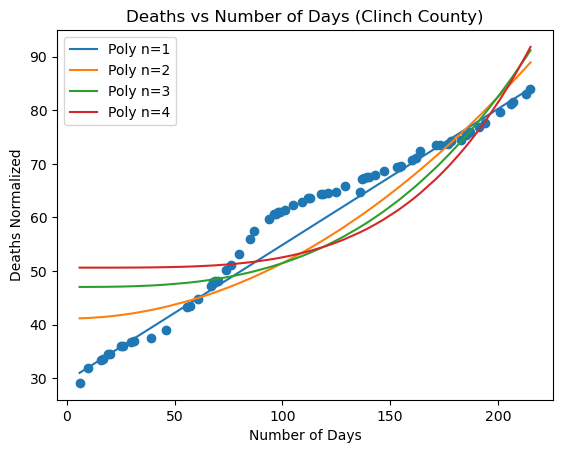

In [53]:
#make our pridict variables
yC_death_predN1 = svr_poly1_clinch_death.predict(xCD_test)
yC_death_predN2 = svr_poly2_clinch_death.predict(xCD_test)
yC_death_predN3 = svr_poly3_clinch_death.predict(xCD_test)
yC_death_predN4 = svr_poly4_clinch_death.predict(xCD_test)

# predict arrays values to dataframes.
xC_test_death_df = pd.DataFrame(xCD_test, columns=['x_test'])
yC_predN1_death_df = pd.DataFrame(yC_death_predN1, columns=['y_predN1'])
yC_predN2_death_df = pd.DataFrame(yC_death_predN2, columns=['y_predN2'])
yC_predN3_death_df = pd.DataFrame(yC_death_predN3, columns=['y_predN3'])
yC_predN4_death_df = pd.DataFrame(yC_death_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_clinch_death = pd.concat([xC_test_death_df, yC_predN1_death_df], axis=1)
poly2_clinch_death = pd.concat([xC_test_death_df, yC_predN2_death_df], axis=1)
poly3_clinch_death = pd.concat([xC_test_death_df, yC_predN3_death_df], axis=1)
poly4_clinch_death = pd.concat([xC_test_death_df, yC_predN4_death_df], axis=1)

# Sort the values by the predict values.
poly1_clinch_death = poly1_clinch_death.sort_values(by=['y_predN1'], ascending=True)
poly2_clinch_death = poly2_clinch_death.sort_values(by=['y_predN2'], ascending=True)
poly3_clinch_death = poly3_clinch_death.sort_values(by=['y_predN3'], ascending=True)
poly4_clinch_death = poly4_clinch_death.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xCD_test, yCD_test)
plt.plot(poly1_clinch_death.x_test, poly1_clinch_death.y_predN1, label="Poly n=1")
plt.plot(poly2_clinch_death.x_test, poly2_clinch_death.y_predN2, label="Poly n=2")
plt.plot(poly3_clinch_death.x_test, poly3_clinch_death.y_predN3, label="Poly n=3")
plt.plot(poly4_clinch_death.x_test, poly4_clinch_death.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Deaths vs Number of Days (Clinch County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
DC_mse = mean_squared_error(y_true=yCD_test, y_pred=yCD_pred, squared=True)
DC_rmse = mean_squared_error(y_true=yCD_test, y_pred=yCD_pred, squared=False)
print("- MSE:",DC_mse)
print("- RMSE:",DC_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
DCn1_mse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN1_death_df, squared=True)
DCn1_rmse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN1_death_df, squared=False)
print("- MSE:",DCn1_mse)
print("- RMSE:",DCn1_rmse)

# for n=2
print("\n- n=2")
DCn2_mse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN2_death_df, squared=True)
DCn2_rmse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN2_death_df, squared=False)
print("- MSE:",DCn2_mse)
print("- RMSE:",DCn2_rmse)

# for n=3
print("\n- n=3")
DCn3_mse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN3_death_df, squared=True)
DCn3_rmse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN3_death_df, squared=False)
print("- MSE:",DCn3_mse)
print("- RMSE:",DCn3_rmse)

# for n=4
print("\n- n=4")
DCn4_mse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN4_death_df, squared=True)
DCn4_rmse = mean_squared_error(y_true=yCD_test, y_pred=yC_predN4_death_df, squared=False)
print("- MSE:",DCn4_mse)
print("- RMSE:",DCn4_rmse)


Linear Cases Regression model:

- MSE: 8.879614513356334
- RMSE: 2.9798682040245223

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 9.43991590609953
- RMSE: 3.0724446140003128

- n=2
- MSE: 38.045872057662244
- RMSE: 6.168133595964199

- n=3
- MSE: 65.08655839341935
- RMSE: 8.067624086025535

- n=4
- MSE: 87.40360955089277
- RMSE: 9.348989760979139


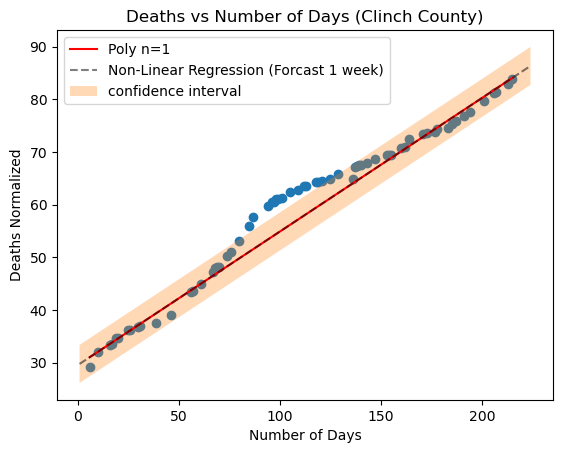

In [55]:
# this is for the future forcast
xCD_pred = np.array(test_CD.Num_of_Days).reshape(-1, 1)
yCD1_pred = svr_poly1_clinch_death.predict(xCD_pred)

xCD_predf = pd.DataFrame(xCD_pred, columns=['xC_pred'])
yCD_predf = pd.DataFrame(yCD1_pred, columns=['yC_pred'])

# ploting the confidence interval
pred_clinch_death = pd.concat([xCD_predf, yCD_predf], axis=1)
pred_clinch_death = pred_clinch_death.sort_values(by=['yC_pred'], ascending=True)

# plot our values.
plt.scatter(xCD_test, yCD_test)
plt.plot(poly1_clinch_death.x_test, poly1_clinch_death.y_predN1, label="Poly n=1", color='red')
plt.plot(pred_clinch_death.xC_pred, pred_clinch_death.yC_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
cid = 3.291 * np.std(yCD1_pred)/np.sqrt(len(xCD_pred))
plt.fill_between(pred_clinch_death.xC_pred, (pred_clinch_death.yC_pred-cid), (pred_clinch_death.yC_pred+cid), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Deaths vs Number of Days (Clinch County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

# GA - Decatur County
### Regressions and Models, prediction path, RSMV and Confidence Intervals.

#### Here we start setting up our model to work with the data of Decatur County, to start we set up our x and y variables.

In [56]:
# Used to set the date ranges and make our forcast line.
train_DC = df_DecatCases_Sum[df_DecatCases_Sum.Num_of_Days <= 217]
test_DC = df_DecatCases_Sum

# Set our x and y values for our models for Decatur County.
# x is number of days.
# y is number of new cases
x_DC_cases = np.array(train_DC.Num_of_Days).reshape(-1, 1)
y_DC_cases = np.array(train_DC.Cases).reshape(-1, 1)

xDC_train,xDC_test,yDC_train,yDC_test=train_test_split(x_DC_cases, y_DC_cases, test_size=0.3, random_state=42)

In [57]:
# setting up our linear model.
svr_lin_decat = SVR(kernel="linear")
svr_lin_decat.fit(xDC_train, yDC_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_decat = SVR(kernel="poly", degree=1)
svr_poly2_decat = SVR(kernel="poly", degree=2)
svr_poly3_decat = SVR(kernel="poly", degree=3)
svr_poly4_decat = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_decat.fit(xDC_train, yDC_train.ravel())
svr_poly2_decat.fit(xDC_train, yDC_train.ravel())
svr_poly3_decat.fit(xDC_train, yDC_train.ravel())
svr_poly4_decat.fit(xDC_train, yDC_train.ravel())

SVR(degree=4, kernel='poly')

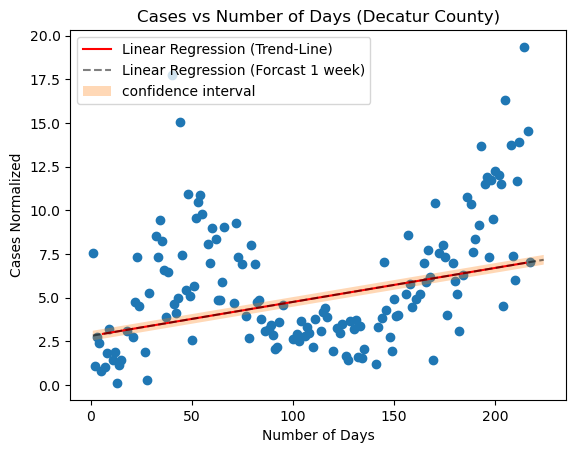

In [58]:
# this prediction is for the trend line.
yDC_pred = svr_lin_decat.predict(xDC_test)

xDC_test_df = pd.DataFrame(xDC_test, columns=['xDC_test'])
yDC_lin_df = pd.DataFrame(yDC_pred, columns=['yDC_pred'])

# ploting the confidence interval
lin_decat = pd.concat([xDC_test_df, yDC_lin_df], axis=1)
lin_decat = lin_decat.sort_values(by=['yDC_pred'], ascending=True)

# this is for the future forcast
xDC_pred = np.array(test_DC.Num_of_Days).reshape(-1, 1)
yDC1_pred = svr_lin_decat.predict(xDC_pred)

xDC_pred_df = pd.DataFrame(xDC_pred, columns=['xD_pred'])
yDC_pred_df = pd.DataFrame(yDC1_pred, columns=['yD_pred'])

# used for the confidence interval
pred_decat = pd.concat([xDC_pred_df, yDC_pred_df], axis=1)
pred_decat = pred_decat.sort_values(by=['yD_pred'], ascending=True)
# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yDC1_pred)/np.sqrt(len(xDC_pred))) #*5

# ploting the data from Decatur County
plt.scatter(xDC_train, yDC_train)
# trend line of the data.
plt.plot(lin_decat.xDC_test, lin_decat.yDC_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_decat.xD_pred, pred_decat.yD_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_decat.xD_pred, (pred_decat.yD_pred-ci), (pred_decat.yD_pred+ci), alpha=.3, label="confidence interval")

plt.title('Cases vs Number of Days (Decatur County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')
plt.legend()
plt.show()

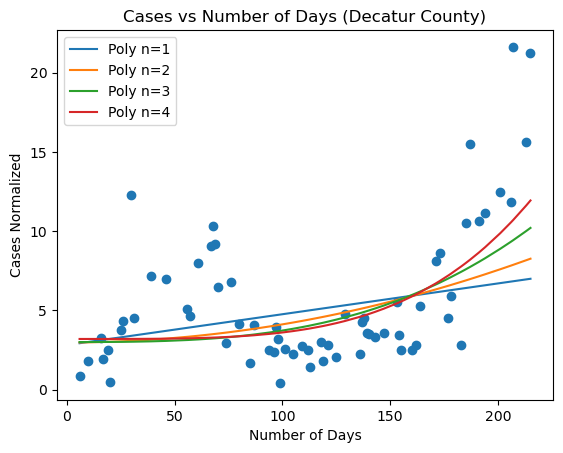

In [59]:
#make our pridict variables
yDC_predN1 = svr_poly1_decat.predict(xDC_test)
yDC_predN2 = svr_poly2_decat.predict(xDC_test)
yDC_predN3 = svr_poly3_decat.predict(xDC_test)
yDC_predN4 = svr_poly4_decat.predict(xDC_test)

# predict arrays values to dataframes.
xDC_test_df = pd.DataFrame(xDC_test, columns=['x_test'])
yDC_predN1_df = pd.DataFrame(yDC_predN1, columns=['y_predN1'])
yDC_predN2_df = pd.DataFrame(yDC_predN2, columns=['y_predN2'])
yDC_predN3_df = pd.DataFrame(yDC_predN3, columns=['y_predN3'])
yDC_predN4_df = pd.DataFrame(yDC_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_decat = pd.concat([xDC_test_df, yDC_predN1_df], axis=1)
poly2_decat = pd.concat([xDC_test_df, yDC_predN2_df], axis=1)
poly3_decat = pd.concat([xDC_test_df, yDC_predN3_df], axis=1)
poly4_decat = pd.concat([xDC_test_df, yDC_predN4_df], axis=1)

# Sort the values by the predict values.
poly1_decat = poly1_decat.sort_values(by=['y_predN1'], ascending=True)
poly2_decat = poly2_decat.sort_values(by=['y_predN2'], ascending=True)
poly3_decat = poly3_decat.sort_values(by=['y_predN3'], ascending=True)
poly4_decat = poly4_decat.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xDC_test, yDC_test)
plt.plot(poly1_decat.x_test, poly1_decat.y_predN1, label="Poly n=1")
plt.plot(poly2_decat.x_test, poly2_decat.y_predN2, label="Poly n=2")
plt.plot(poly3_decat.x_test, poly3_decat.y_predN3, label="Poly n=3")
plt.plot(poly4_decat.x_test, poly4_decat.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Cases vs Number of Days (Decatur County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
CD_mse = mean_squared_error(y_true=yDC_test, y_pred=yDC_pred, squared=True)
CD_rmse = mean_squared_error(y_true=yDC_test, y_pred=yDC_pred, squared=False)
print("- MSE:",CD_mse)
print("- RMSE:",CD_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
CDn1_mse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN1_df, squared=True)
CDn1_rmse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN1_df, squared=False)
print("- MSE:",CDn1_mse)
print("- RMSE:",CDn1_rmse)

# for n=2
print("\n- n=2")
CDn2_mse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN2_df, squared=True)
CDn2_rmse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN2_df, squared=False)
print("- MSE:",CDn2_mse)
print("- RMSE:",CDn2_rmse)

# for n=3
print("\n- n=3")
CDn3_mse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN3_df, squared=True)
CDn3_rmse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN3_df, squared=False)
print("- MSE:",CDn3_mse)
print("- RMSE:",CDn3_rmse)

# for n=4
print("\n- n=4")
CDn4_mse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN4_df, squared=True)
CDn4_rmse = mean_squared_error(y_true=yDC_test, y_pred=yDC_predN4_df, squared=False)
print("- MSE:",CDn4_mse)
print("- RMSE:",CDn4_rmse)


Linear Cases Regression model:

- MSE: 17.184255026581827
- RMSE: 4.145389610951162

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 17.184259708565428
- RMSE: 4.145390175672904

- n=2
- MSE: 15.316991856583252
- RMSE: 3.913692866920353

- n=3
- MSE: 12.930343343698443
- RMSE: 3.595878660869752

- n=4
- MSE: 11.061543215228854
- RMSE: 3.325889838107819


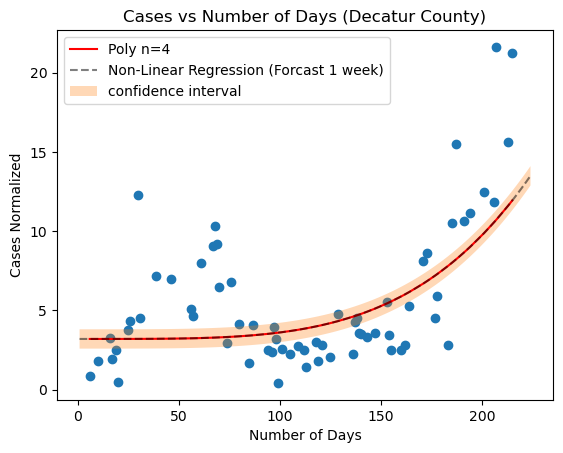

In [61]:
# this is for the future forcast
xDC_pred = np.array(test_DC.Num_of_Days).reshape(-1, 1)
yDC1_pred = svr_poly4_decat.predict(xDC_pred)

xDC_pre_df = pd.DataFrame(xDC_pred, columns=['xDC_pred'])
yDC_pre_df = pd.DataFrame(yDC1_pred, columns=['yDC_pred'])

# ploting the confidence interval
pred_decat = pd.concat([xDC_pre_df, yDC_pre_df], axis=1)
pred_decat = pred_decat.sort_values(by=['yDC_pred'], ascending=True)

# plot our values.
plt.scatter(xDC_test, yDC_test)
plt.plot(poly4_decat.x_test, poly4_decat.y_predN4, label="Poly n=4", color='red')
plt.plot(pred_decat.xDC_pred, pred_decat.yDC_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
ci = 3.291 * np.std(yDC1_pred)/np.sqrt(len(xDC_pred))
plt.fill_between(pred_decat.xDC_pred, (pred_decat.yDC_pred-ci), (pred_decat.yDC_pred+ci), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Cases vs Number of Days (Decatur County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Repeat process for deaths in Decatur County

In [62]:
# Used to set the date ranges and make our forcast line.
train_DD = df_DecatDeath_Sum[df_DecatDeath_Sum.Num_of_Days <= 217]
test_DD = df_DecatDeath_Sum

# Set our x and y values for our models for Franklin County.
# x is number of days.
# y is number of new deaths.
xD_death = np.array(train_DD.Num_of_Days).reshape(-1, 1)
yD_death = np.array(train_DD.Deaths).reshape(-1, 1)

xDD_train,xDD_test,yDD_train,yDD_test=train_test_split(xD_death, yD_death, test_size=0.3, random_state=42)

In [63]:
# setting up our linear model.
svr_lin_decat_death = SVR(kernel="linear")
svr_lin_decat_death.fit(xDD_train, yDD_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_decat_death = SVR(kernel="poly", degree=1)
svr_poly2_decat_death = SVR(kernel="poly", degree=2)
svr_poly3_decat_death = SVR(kernel="poly", degree=3)
svr_poly4_decat_death = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_decat_death.fit(xDD_train, yDD_train.ravel())
svr_poly2_decat_death.fit(xDD_train, yDD_train.ravel())
svr_poly3_decat_death.fit(xDD_train, yDD_train.ravel())
svr_poly4_decat_death.fit(xDD_train, yDD_train.ravel())

SVR(degree=4, kernel='poly')

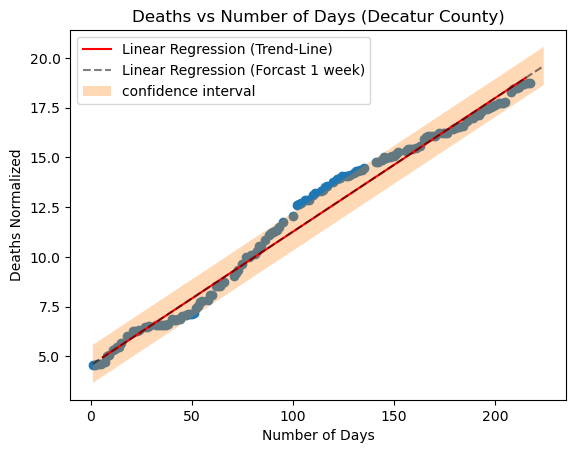

In [64]:
# this prediction is for the trend line.
yDD_pred = svr_lin_decat_death.predict(xDD_test)

xD_lin_df = pd.DataFrame(xDD_test, columns=['xDD_test'])
yD_lin_df = pd.DataFrame(yDD_pred, columns=['yDD_pred'])

# ploting the confidence interval
lin_decat_death = pd.concat([xD_lin_df, yD_lin_df], axis=1)
lin_decat_death = lin_decat_death.sort_values(by=['yDD_pred'], ascending=True)

# this is for the future forcast
xD_pred_death = np.array(test_DD.Num_of_Days).reshape(-1, 1)
yD1_pred_death = svr_lin_decat_death.predict(xD_pred_death)

xDD_pre_df = pd.DataFrame(xD_pred_death, columns=['xDD_pred'])
yDD_pre_df = pd.DataFrame(yD1_pred_death, columns=['yDD_pred'])

# used for the confidence interval
pred_decat_death = pd.concat([xDD_pre_df, yDD_pre_df], axis=1)
pred_decat_death = pred_decat_death.sort_values(by=['yDD_pred'], ascending=True)

# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yD1_pred_death)/np.sqrt(len(xD_pred_death)))

# ploting the data from Decatur County deaths
plt.scatter(xDD_train, yDD_train)
# trend line of the data.
plt.plot(lin_decat_death.xDD_test, lin_decat_death.yDD_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_decat_death.xDD_pred, pred_decat_death.yDD_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_decat_death.xDD_pred, (pred_decat_death.yDD_pred-ci), (pred_decat_death.yDD_pred+ci), alpha=.3, label="confidence interval")

plt.title('Deaths vs Number of Days (Decatur County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')
plt.legend()
plt.show()

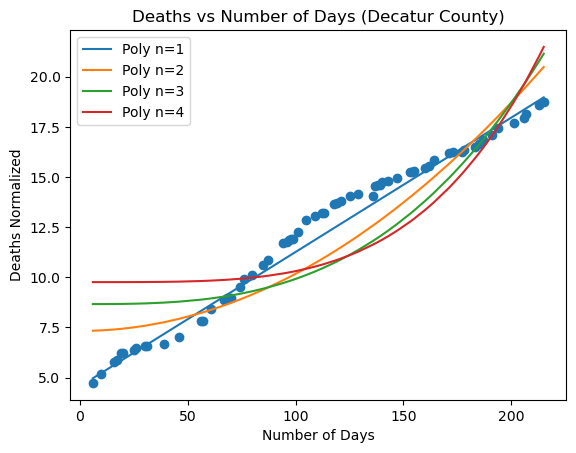

In [65]:
#make our pridict variables
yD_death_predN1 = svr_poly1_decat_death.predict(xDD_test)
yD_death_predN2 = svr_poly2_decat_death.predict(xDD_test)
yD_death_predN3 = svr_poly3_decat_death.predict(xDD_test)
yD_death_predN4 = svr_poly4_decat_death.predict(xDD_test)

# predict arrays values to dataframes.
xD_test_death_df = pd.DataFrame(xDD_test, columns=['x_test'])
yD_predN1_death_df = pd.DataFrame(yD_death_predN1, columns=['y_predN1'])
yD_predN2_death_df = pd.DataFrame(yD_death_predN2, columns=['y_predN2'])
yD_predN3_death_df = pd.DataFrame(yD_death_predN3, columns=['y_predN3'])
yD_predN4_death_df = pd.DataFrame(yD_death_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_decat_death = pd.concat([xD_test_death_df, yD_predN1_death_df], axis=1)
poly2_decat_death = pd.concat([xD_test_death_df, yD_predN2_death_df], axis=1)
poly3_decat_death = pd.concat([xD_test_death_df, yD_predN3_death_df], axis=1)
poly4_decat_death = pd.concat([xD_test_death_df, yD_predN4_death_df], axis=1)

# Sort the values by the predict values.
poly1_decat_death = poly1_decat_death.sort_values(by=['y_predN1'], ascending=True)
poly2_decat_death = poly2_decat_death.sort_values(by=['y_predN2'], ascending=True)
poly3_decat_death = poly3_decat_death.sort_values(by=['y_predN3'], ascending=True)
poly4_decat_death = poly4_decat_death.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xDD_test, yDD_test)
plt.plot(poly1_decat_death.x_test, poly1_decat_death.y_predN1, label="Poly n=1")
plt.plot(poly2_decat_death.x_test, poly2_decat_death.y_predN2, label="Poly n=2")
plt.plot(poly3_decat_death.x_test, poly3_decat_death.y_predN3, label="Poly n=3")
plt.plot(poly4_decat_death.x_test, poly4_decat_death.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Deaths vs Number of Days (Decatur County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

In [66]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
DD_mse = mean_squared_error(y_true=yDD_test, y_pred=yDD_pred, squared=True)
DD_rmse = mean_squared_error(y_true=yDD_test, y_pred=yDD_pred, squared=False)
print("- MSE:",DD_mse)
print("- RMSE:",DD_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
DDn1_mse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN1_death_df, squared=True)
DDn1_rmse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN1_death_df, squared=False)
print("- MSE:",DDn1_mse)
print("- RMSE:",DDn1_rmse)

# for n=2
print("\n- n=2")
DDn2_mse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN2_death_df, squared=True)
DDn2_rmse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN2_death_df, squared=False)
print("- MSE:",DDn2_mse)
print("- RMSE:",DDn2_rmse)

# for n=3
print("\n- n=3")
DDn3_mse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN3_death_df, squared=True)
DDn3_rmse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN3_death_df, squared=False)
print("- MSE:",DDn3_mse)
print("- RMSE:",DDn3_rmse)

# for n=4
print("\n- n=4")
DDn4_mse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN4_death_df, squared=True)
DDn4_rmse = mean_squared_error(y_true=yDD_test, y_pred=yD_predN4_death_df, squared=False)
print("- MSE:",DDn4_mse)
print("- RMSE:",DDn4_rmse)


Linear Cases Regression model:

- MSE: 0.34195740784343776
- RMSE: 0.5847712440291826

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 0.3461212844221736
- RMSE: 0.5883207326128951

- n=2
- MSE: 2.133304500736678
- RMSE: 1.460583616482356

- n=3
- MSE: 4.148670812505587
- RMSE: 2.0368286163802756

- n=4
- MSE: 5.647558206020514
- RMSE: 2.3764591740697996


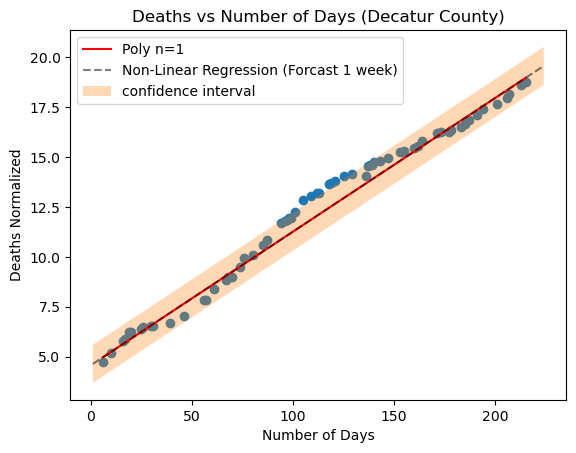

In [67]:
# this is for the future forcast
xDD_pred = np.array(test_DD.Num_of_Days).reshape(-1, 1)
yDD1_pred = svr_poly1_decat_death.predict(xDD_pred)

xDD_predf = pd.DataFrame(xDD_pred, columns=['xD_pred'])
yDD_predf = pd.DataFrame(yDD1_pred, columns=['yD_pred'])

# ploting the confidence interval
pred_decat_death = pd.concat([xDD_predf, yDD_predf], axis=1)
pred_decat_death = pred_decat_death.sort_values(by=['yD_pred'], ascending=True)

# plot our values.
plt.scatter(xDD_test, yDD_test)
plt.plot(poly1_decat_death.x_test, poly1_decat_death.y_predN1, label="Poly n=1", color='red')
plt.plot(pred_decat_death.xD_pred, pred_decat_death.yD_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
cid = 3.291 * np.std(yDD1_pred)/np.sqrt(len(xDD_pred))
plt.fill_between(pred_decat_death.xD_pred, (pred_decat_death.yD_pred-cid), (pred_decat_death.yD_pred+cid), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Deaths vs Number of Days (Decatur County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

# GA - Habersham County
### Regressions and Models, prediction path, RSMV and Confidence Intervals.

#### Here we start setting up our model to work with the data of Habersham County, to start we set up our x and y variables.

In [68]:
# Used to set the date ranges and make our forcast line.
train_HC = df_HaberCases_Sum[df_HaberCases_Sum.Num_of_Days <= 217]
test_HC = df_HaberCases_Sum

# Set our x and y values for our models for Habersham County.
# x is number of days.
# y is number of new cases
x_HC_cases = np.array(train_HC.Num_of_Days).reshape(-1, 1)
y_HC_cases = np.array(train_HC.Cases).reshape(-1, 1)

xHC_train,xHC_test,yHC_train,yHC_test=train_test_split(x_HC_cases, y_HC_cases, test_size=0.3, random_state=42)

In [69]:
# setting up our linear model.
svr_lin_haber = SVR(kernel="linear")
svr_lin_haber.fit(xHC_train, yHC_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_haber = SVR(kernel="poly", degree=1)
svr_poly2_haber = SVR(kernel="poly", degree=2)
svr_poly3_haber = SVR(kernel="poly", degree=3)
svr_poly4_haber = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_haber.fit(xHC_train, yHC_train.ravel())
svr_poly2_haber.fit(xHC_train, yHC_train.ravel())
svr_poly3_haber.fit(xHC_train, yHC_train.ravel())
svr_poly4_haber.fit(xHC_train, yHC_train.ravel())

SVR(degree=4, kernel='poly')

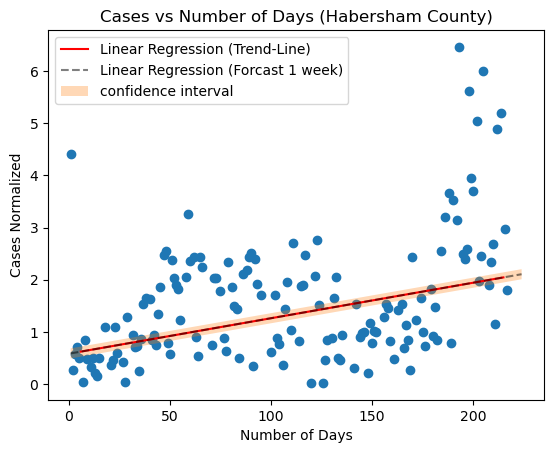

In [70]:
# this prediction is for the trend line.
yHC_pred = svr_lin_haber.predict(xHC_test)

xHC_test_df = pd.DataFrame(xHC_test, columns=['xHC_test'])
yHC_lin_df = pd.DataFrame(yHC_pred, columns=['yHC_pred'])

# ploting the confidence interval
lin_haber = pd.concat([xHC_test_df, yHC_lin_df], axis=1)
lin_haber = lin_haber.sort_values(by=['yHC_pred'], ascending=True)

# this is for the future forcast
xHC_pred = np.array(test_HC.Num_of_Days).reshape(-1, 1)
yHC1_pred = svr_lin_haber.predict(xHC_pred)

xHC_pred_df = pd.DataFrame(xHC_pred, columns=['xH_pred'])
yHC_pred_df = pd.DataFrame(yHC1_pred, columns=['yH_pred'])

# used for the confidence interval
pred_haber = pd.concat([xHC_pred_df, yHC_pred_df], axis=1)
pred_haber = pred_haber.sort_values(by=['yH_pred'], ascending=True)
# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yHC1_pred)/np.sqrt(len(xHC_pred))) #*5

# ploting the data from Habersham County
plt.scatter(xHC_train, yHC_train)
# trend line of the data.
plt.plot(lin_haber.xHC_test, lin_haber.yHC_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_haber.xH_pred, pred_haber.yH_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_haber.xH_pred, (pred_haber.yH_pred-ci), (pred_haber.yH_pred+ci), alpha=.3, label="confidence interval")

plt.title('Cases vs Number of Days (Habersham County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')
plt.legend()
plt.show()

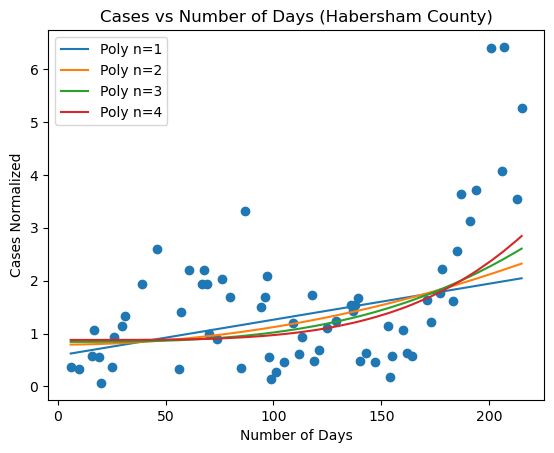

In [71]:
#make our pridict variables
yHC_predN1 = svr_poly1_haber.predict(xHC_test)
yHC_predN2 = svr_poly2_haber.predict(xHC_test)
yHC_predN3 = svr_poly3_haber.predict(xHC_test)
yHC_predN4 = svr_poly4_haber.predict(xHC_test)

# predict arrays values to dataframes.
xHC_test_df = pd.DataFrame(xHC_test, columns=['x_test'])
yHC_predN1_df = pd.DataFrame(yHC_predN1, columns=['y_predN1'])
yHC_predN2_df = pd.DataFrame(yHC_predN2, columns=['y_predN2'])
yHC_predN3_df = pd.DataFrame(yHC_predN3, columns=['y_predN3'])
yHC_predN4_df = pd.DataFrame(yHC_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_haber = pd.concat([xHC_test_df, yHC_predN1_df], axis=1)
poly2_haber = pd.concat([xHC_test_df, yHC_predN2_df], axis=1)
poly3_haber = pd.concat([xHC_test_df, yHC_predN3_df], axis=1)
poly4_haber = pd.concat([xHC_test_df, yHC_predN4_df], axis=1)

# Sort the values by the predict values.
poly1_haber = poly1_haber.sort_values(by=['y_predN1'], ascending=True)
poly2_haber = poly2_haber.sort_values(by=['y_predN2'], ascending=True)
poly3_haber = poly3_haber.sort_values(by=['y_predN3'], ascending=True)
poly4_haber = poly4_haber.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xHC_test, yHC_test)
plt.plot(poly1_haber.x_test, poly1_haber.y_predN1, label="Poly n=1")
plt.plot(poly2_haber.x_test, poly2_haber.y_predN2, label="Poly n=2")
plt.plot(poly3_haber.x_test, poly3_haber.y_predN3, label="Poly n=3")
plt.plot(poly4_haber.x_test, poly4_haber.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Cases vs Number of Days (Habersham County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

In [72]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
CH_mse = mean_squared_error(y_true=yHC_test, y_pred=yHC_pred, squared=True)
CH_rmse = mean_squared_error(y_true=yHC_test, y_pred=yHC_pred, squared=False)
print("- MSE:",CH_mse)
print("- RMSE:",CH_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
CHn1_mse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN1_df, squared=True)
CHn1_rmse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN1_df, squared=False)
print("- MSE:",CHn1_mse)
print("- RMSE:",CHn1_rmse)

# for n=2
print("\n- n=2")
CHn2_mse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN2_df, squared=True)
CHn2_rmse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN2_df, squared=False)
print("- MSE:",CHn2_mse)
print("- RMSE:",CHn2_rmse)

# for n=3
print("\n- n=3")
CHn3_mse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN3_df, squared=True)
CHn3_rmse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN3_df, squared=False)
print("- MSE:",CHn3_mse)
print("- RMSE:",CHn3_rmse)

# for n=4
print("\n- n=4")
CHn4_mse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN4_df, squared=True)
CHn4_rmse = mean_squared_error(y_true=yHC_test, y_pred=yHC_predN4_df, squared=False)
print("- MSE:",CHn4_mse)
print("- RMSE:",CHn4_rmse)


Linear Cases Regression model:

- MSE: 1.4962665413084277
- RMSE: 1.2232197436717689

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 1.496266217638894
- RMSE: 1.2232196113694769

- n=2
- MSE: 1.376528925478853
- RMSE: 1.1732556948418589

- n=3
- MSE: 1.2659377991736316
- RMSE: 1.1251390132661971

- n=4
- MSE: 1.1840808269845644
- RMSE: 1.088154780803064


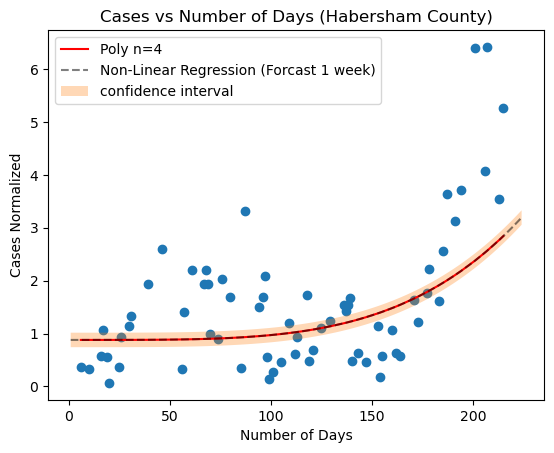

In [73]:
# this is for the future forcast
xHC_pred = np.array(test_HC.Num_of_Days).reshape(-1, 1)
yHC1_pred = svr_poly4_haber.predict(xHC_pred)

xHC_pre_df = pd.DataFrame(xHC_pred, columns=['xHC_pred'])
yHC_pre_df = pd.DataFrame(yHC1_pred, columns=['yHC_pred'])

# ploting the confidence interval
pred_haber = pd.concat([xHC_pre_df, yHC_pre_df], axis=1)
pred_haber = pred_haber.sort_values(by=['yHC_pred'], ascending=True)

# plot our values.
plt.scatter(xHC_test, yHC_test)
plt.plot(poly4_haber.x_test, poly4_haber.y_predN4, label="Poly n=4", color='red')
plt.plot(pred_haber.xHC_pred, pred_haber.yHC_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression (Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
ci = 3.291 * np.std(yHC1_pred)/np.sqrt(len(xHC_pred))
plt.fill_between(pred_haber.xHC_pred, (pred_haber.yHC_pred-ci), (pred_haber.yHC_pred+ci), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Cases vs Number of Days (Habersham County)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Repeat process for deaths in Habersham County

In [74]:
# Used to set the date ranges and make our forcast line.
train_HD = df_HaberDeath_Sum[df_HaberDeath_Sum.Num_of_Days <= 217]
test_HD = df_HaberDeath_Sum

# Set our x and y values for our models for HABERSHAM County.
# x is number of days.
# y is number of new deaths.
xH_death = np.array(train_HD.Num_of_Days).reshape(-1, 1)
yH_death = np.array(train_HD.Deaths).reshape(-1, 1)

xHD_train,xHD_test,yHD_train,yHD_test=train_test_split(xH_death, yH_death, test_size=0.3, random_state=42)

In [75]:
# setting up our linear model.
svr_lin_haber_death = SVR(kernel="linear")
svr_lin_haber_death.fit(xHD_train, yHD_train.ravel())

# This is our SVR training our non-linear model.
# this is using a poly regresion.
svr_poly1_haber_death = SVR(kernel="poly", degree=1)
svr_poly2_haber_death = SVR(kernel="poly", degree=2)
svr_poly3_haber_death = SVR(kernel="poly", degree=3)
svr_poly4_haber_death = SVR(kernel="poly", degree=4)

# Train the non linear model.
svr_poly1_haber_death.fit(xHD_train, yHD_train.ravel())
svr_poly2_haber_death.fit(xHD_train, yHD_train.ravel())
svr_poly3_haber_death.fit(xHD_train, yHD_train.ravel())
svr_poly4_haber_death.fit(xHD_train, yHD_train.ravel())

SVR(degree=4, kernel='poly')

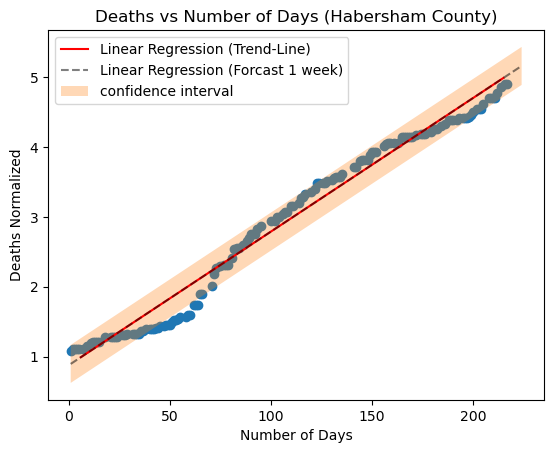

In [76]:
# this prediction is for the trend line.
yHD_pred = svr_lin_haber_death.predict(xHD_test)

xH_lin_df = pd.DataFrame(xHD_test, columns=['xHD_test'])
yH_lin_df = pd.DataFrame(yHD_pred, columns=['yHD_pred'])

# ploting the confidence interval
lin_haber_death = pd.concat([xH_lin_df, yH_lin_df], axis=1)
lin_haber_death = lin_haber_death.sort_values(by=['yHD_pred'], ascending=True)

# this is for the future forcast
xH_pred_death = np.array(test_HD.Num_of_Days).reshape(-1, 1)
yH1_pred_death = svr_lin_haber_death.predict(xH_pred_death)

xHD_pre_df = pd.DataFrame(xH_pred_death, columns=['xHD_pred'])
yHD_pre_df = pd.DataFrame(yH1_pred_death, columns=['yHD_pred'])

# used for the confidence interval
pred_haber_death = pd.concat([xHD_pre_df, yHD_pre_df], axis=1)
pred_haber_death = pred_haber_death.sort_values(by=['yHD_pred'], ascending=True)

# using a z-value 3.291 for 99.9% CI level
ci = (3.291 * np.std(yH1_pred_death)/np.sqrt(len(xH_pred_death)))

# ploting the data from Habersham County deaths
plt.scatter(xHD_train, yHD_train)
# trend line of the data.
plt.plot(lin_haber_death.xHD_test, lin_haber_death.yHD_pred, label='Linear Regression (Trend-Line)', color='red')
# forcast of the data 1 week ahead day 218 to 224
plt.plot(pred_haber_death.xHD_pred, pred_haber_death.yHD_pred, linestyle='--', alpha=0.5, color='black', label='Linear Regression (Forcast 1 week)')
# ploting the confidence interval
plt.fill_between(pred_haber_death.xHD_pred, (pred_haber_death.yHD_pred-ci), (pred_haber_death.yHD_pred+ci), alpha=.3, label="confidence interval")

plt.title('Deaths vs Number of Days (Habersham County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')
plt.legend()
plt.show()

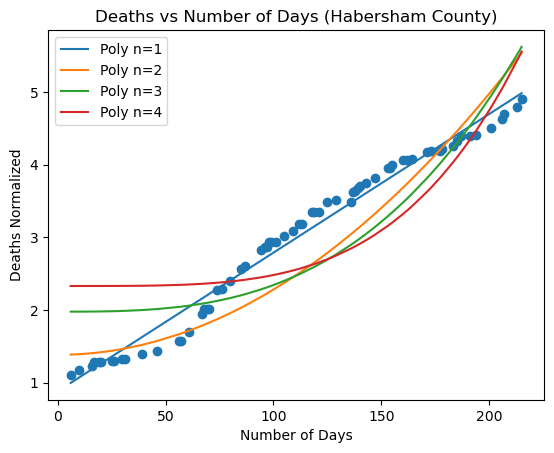

In [77]:
#make our pridict variables
yH_death_predN1 = svr_poly1_haber_death.predict(xHD_test)
yH_death_predN2 = svr_poly2_haber_death.predict(xHD_test)
yH_death_predN3 = svr_poly3_haber_death.predict(xHD_test)
yH_death_predN4 = svr_poly4_haber_death.predict(xHD_test)

# predict arrays values to dataframes.
xH_test_death_df = pd.DataFrame(xHD_test, columns=['x_test'])
yH_predN1_death_df = pd.DataFrame(yH_death_predN1, columns=['y_predN1'])
yH_predN2_death_df = pd.DataFrame(yH_death_predN2, columns=['y_predN2'])
yH_predN3_death_df = pd.DataFrame(yH_death_predN3, columns=['y_predN3'])
yH_predN4_death_df = pd.DataFrame(yH_death_predN4, columns=['y_predN4'])

# concat the predict arrays with x_test values.
poly1_haber_death = pd.concat([xH_test_death_df, yH_predN1_death_df], axis=1)
poly2_haber_death = pd.concat([xH_test_death_df, yH_predN2_death_df], axis=1)
poly3_haber_death = pd.concat([xH_test_death_df, yH_predN3_death_df], axis=1)
poly4_haber_death = pd.concat([xH_test_death_df, yH_predN4_death_df], axis=1)

# Sort the values by the predict values.
poly1_haber_death = poly1_haber_death.sort_values(by=['y_predN1'], ascending=True)
poly2_haber_death = poly2_haber_death.sort_values(by=['y_predN2'], ascending=True)
poly3_haber_death = poly3_haber_death.sort_values(by=['y_predN3'], ascending=True)
poly4_haber_death = poly4_haber_death.sort_values(by=['y_predN4'], ascending=True)

# plot our values.
plt.scatter(xHD_test, yHD_test)
plt.plot(poly1_haber_death.x_test, poly1_haber_death.y_predN1, label="Poly n=1")
plt.plot(poly2_haber_death.x_test, poly2_haber_death.y_predN2, label="Poly n=2")
plt.plot(poly3_haber_death.x_test, poly3_haber_death.y_predN3, label="Poly n=3")
plt.plot(poly4_haber_death.x_test, poly4_haber_death.y_predN4, label="Poly n=4")

# Add titles and labels
plt.title('Deaths vs Number of Days (Habersham County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

In [78]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Time to find our RMSE values for our models.
# Cases Linear model
print("\nLinear Cases Regression model:\n")
DH_mse = mean_squared_error(y_true=yHD_test, y_pred=yHD_pred, squared=True)
DH_rmse = mean_squared_error(y_true=yHD_test, y_pred=yHD_pred, squared=False)
print("- MSE:",DH_mse)
print("- RMSE:",DH_rmse)

# Cases Non Linear model
print("\nNon-Linear Cases Regression model (n=1 through n=4):\n")
print("- n=1")
DHn1_mse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN1_death_df, squared=True)
DHn1_rmse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN1_death_df, squared=False)
print("- MSE:",DHn1_mse)
print("- RMSE:",DHn1_rmse)

# for n=2
print("\n- n=2")
DHn2_mse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN2_death_df, squared=True)
DHn2_rmse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN2_death_df, squared=False)
print("- MSE:",DHn2_mse)
print("- RMSE:",DHn2_rmse)

# for n=3
print("\n- n=3")
DHn3_mse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN3_death_df, squared=True)
DHn3_rmse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN3_death_df, squared=False)
print("- MSE:",DHn3_mse)
print("- RMSE:",DHn3_rmse)

# for n=4
print("\n- n=4")
DHn4_mse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN4_death_df, squared=True)
DHn4_rmse = mean_squared_error(y_true=yHD_test, y_pred=yH_predN4_death_df, squared=False)
print("- MSE:",DHn4_mse)
print("- RMSE:",DHn4_rmse)


Linear Cases Regression model:

- MSE: 0.025092713833135036
- RMSE: 0.15840679856980583

Non-Linear Cases Regression model (n=1 through n=4):

- n=1
- MSE: 0.025180853006643942
- RMSE: 0.15868475984367225

- n=2
- MSE: 0.19826712816999031
- RMSE: 0.44527197101321153

- n=3
- MSE: 0.3213338705492936
- RMSE: 0.5668631850361192

- n=4
- MSE: 0.45837652838262594
- RMSE: 0.6770351012928546


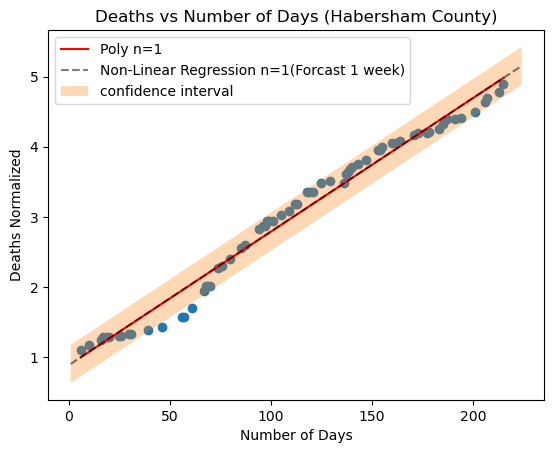

In [79]:
# this is for the future forcast
xHD_pred = np.array(test_HD.Num_of_Days).reshape(-1, 1)
yHD1_pred = svr_poly1_haber_death.predict(xHD_pred)

xHD_predf = pd.DataFrame(xHD_pred, columns=['xH_pred'])
yHD_predf = pd.DataFrame(yHD1_pred, columns=['yH_pred'])

# ploting the confidence interval
pred_haber_death = pd.concat([xHD_predf, yHD_predf], axis=1)
pred_haber_death = pred_haber_death.sort_values(by=['yH_pred'], ascending=True)

# plot our values.
plt.scatter(xHD_test, yHD_test)
plt.plot(poly1_haber_death.x_test, poly1_haber_death.y_predN1, label="Poly n=1", color='red')
plt.plot(pred_haber_death.xH_pred, pred_haber_death.yH_pred, linestyle='--', alpha=0.5, color='black', label='Non-Linear Regression n=1(Forcast 1 week)')

# plotting the confidence interval
# 3.91 is the Z socre for a 99.9% CI level
cid = 3.291 * np.std(yHD1_pred)/np.sqrt(len(xHD_pred))
plt.fill_between(pred_haber_death.xH_pred, (pred_haber_death.yH_pred-cid), (pred_haber_death.yH_pred+cid), alpha=.3, label="confidence interval")

# Add titles and labels
plt.title('Deaths vs Number of Days (Habersham County)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')

plt.legend()
plt.show()

## Identifiy which counties are most at risk.

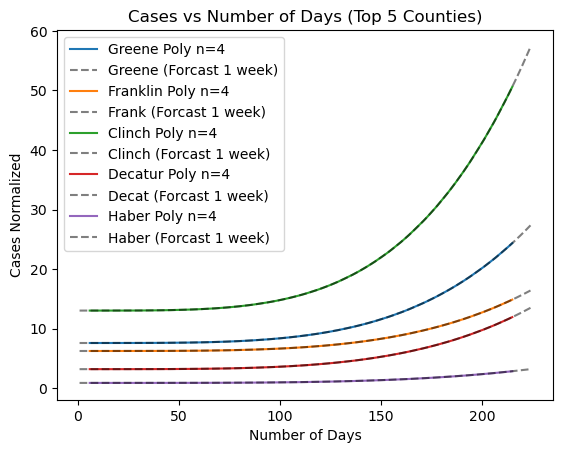

In [80]:
# first we will look at the cases in each county.
# we utilize the non reg lines that had the lowest RMSE vlaues
plt.plot(poly4_greene.x_test, poly4_greene.y_predN4, label="Greene Poly n=4")
plt.plot(pred_greene.xg_pred, pred_greene.yg_pred, linestyle='--', alpha=0.5, color='black', label='Greene (Forcast 1 week)')

plt.plot(poly4_frank.x_test, poly4_frank.y_predN4, label="Franklin Poly n=4")
plt.plot(pred_frank.xFC_pred, pred_frank.yFC_pred, linestyle='--', alpha=0.5, color='black', label='Frank (Forcast 1 week)')

plt.plot(poly4_clinch.x_test, poly4_clinch.y_predN4, label="Clinch Poly n=4")
plt.plot(pred_clinch.xCC_pred, pred_clinch.yCC_pred, linestyle='--', alpha=0.5, color='black', label='Clinch (Forcast 1 week)')

plt.plot(poly4_decat.x_test, poly4_decat.y_predN4, label="Decatur Poly n=4")
plt.plot(pred_decat.xDC_pred, pred_decat.yDC_pred, linestyle='--', alpha=0.5, color='black', label='Decat (Forcast 1 week)')

plt.plot(poly4_haber.x_test, poly4_haber.y_predN4, label="Haber Poly n=4")
plt.plot(pred_haber.xHC_pred, pred_haber.yHC_pred, linestyle='--', alpha=0.5, color='black', label='Haber (Forcast 1 week)')


# Add titles and labels
plt.title('Cases vs Number of Days (Top 5 Counties)')
plt.xlabel('Number of Days')
plt.ylabel('Cases Normalized')

plt.legend()
plt.show()

### Looking at the non-linear regression from all 5 counties cases we can see that the county that is in the most trouble is Clinch county which is higher than the other counties and is forecasted to grow even quicker.

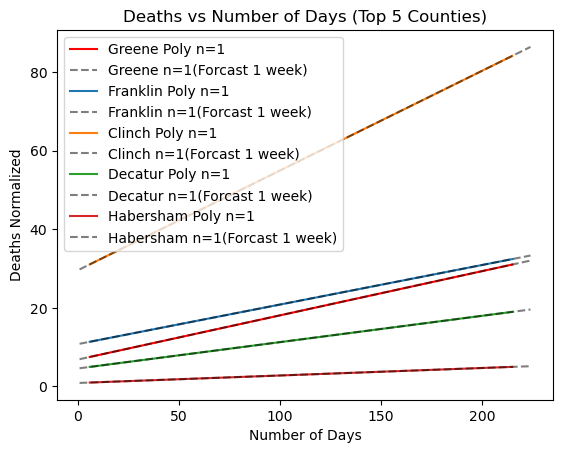

In [81]:
# Now we can look at the deaths.
# we utilize the non reg lines that had the lowest RMSE vlaues
plt.plot(poly1_greene_death.x_test, poly1_greene_death.y_predN1, label="Greene Poly n=1", color='red')
plt.plot(pred_greene_death.xg_pred, pred_greene_death.yg_pred, linestyle='--', alpha=0.5, color='black', label='Greene n=1(Forcast 1 week)')

plt.plot(poly1_frank_death.x_test, poly1_frank_death.y_predN1, label="Franklin Poly n=1")
plt.plot(pred_frank_death.xF_pred, pred_frank_death.yF_pred, linestyle='--', alpha=0.5, color='black', label='Franklin n=1(Forcast 1 week)')

plt.plot(poly1_clinch_death.x_test, poly1_clinch_death.y_predN1, label="Clinch Poly n=1")
plt.plot(pred_clinch_death.xC_pred, pred_clinch_death.yC_pred, linestyle='--', alpha=0.5, color='black', label='Clinch n=1(Forcast 1 week)')

plt.plot(poly1_decat_death.x_test, poly1_decat_death.y_predN1, label="Decatur Poly n=1")
plt.plot(pred_decat_death.xD_pred, pred_decat_death.yD_pred, linestyle='--', alpha=0.5, color='black', label='Decatur n=1(Forcast 1 week)')

plt.plot(poly1_haber_death.x_test, poly1_haber_death.y_predN1, label="Habersham Poly n=1")
plt.plot(pred_haber_death.xH_pred, pred_haber_death.yH_pred, linestyle='--', alpha=0.5, color='black', label='Habersham n=1(Forcast 1 week)')

plt.title('Deaths vs Number of Days (Top 5 Counties)')
plt.xlabel('Number of Days')
plt.ylabel('Deaths Normalized')


plt.legend()
plt.show()

### Looking at the non-linear regression from all 5 counties deaths forecast, we can see that Clinch county is also in much more trouble when compared to the other top 5 counties.

# Hypothesis Testing

In [82]:
cov23 = pd.read_csv('censusEnrichData.csv')
cov23.head()

,Unnamed: 0,countyFIPS,County Name,State_x,population,Male,Female,Under 18 years,18 years and over,65 years and over
0,0,1003,Baldwin County,AL,223234,"120,664","125,771","51,269","195,166","53,946"
1,1,1015,Calhoun County,AL,113605,"56,554","59,234","24,410","91,378","21,445"
2,2,1043,Cullman County,AL,83768,"45,051","45,614","20,170","70,495","17,376"
3,3,1049,DeKalb County,AL,71513,"36,024","35,974","17,043","54,955","12,763"
4,4,1051,Elmore County,AL,81209,"43,448","46,115","18,970","70,593","14,594"


In [83]:
enrichMer = cov23.copy(deep=True)
# altering the data so it can be refrenced more easily.
enrichMer['Male']=enrichMer['Male'].str.replace(',','')
enrichMer['Female']=enrichMer['Female'].str.replace(',','')
enrichMer['18 years and over']=enrichMer['18 years and over'].str.replace(',','')
enrichMer['Under 18 years']=enrichMer['Under 18 years'].str.replace(',','')
enrichMer['65 years and over']=enrichMer['65 years and over'].str.replace(',','')

enrichMer['Male'] = pd.to_numeric(enrichMer['Male'])
enrichMer['Female'] = pd.to_numeric(enrichMer['Female'])
enrichMer['18 years and over'] = pd.to_numeric(enrichMer['18 years and over'])
enrichMer['Under 18 years'] = pd.to_numeric(enrichMer['Under 18 years'])
enrichMer['65 years and over'] = pd.to_numeric(enrichMer['65 years and over'])

# narrow down the data set to GA
enrichMer = enrichMer[enrichMer['State_x'] == 'GA']

# Calculate the the Ratio of males to the total population of a county.
enrichMer['Ratio of Males to Pop'] = enrichMer.apply(lambda row: row.Male / row.population, axis = 1)
enrichMer.head()

,Unnamed: 0,countyFIPS,County Name,State_x,population,Male,Female,Under 18 years,18 years and over,65 years and over,Ratio of Males to Pop
140,140,13013,Barrow County,GA,83240,43604,45695,22202,67097,11728,0.523835
141,141,13015,Bartow County,GA,107738,54917,57899,25830,86986,15946,0.509727
142,142,13021,Bibb County,GA,153159,73370,82827,37693,118504,26649,0.479045
143,143,13031,Bulloch County,GA,79608,40564,42495,16261,66798,10106,0.509547
144,144,13045,Carroll County,GA,119992,61197,63395,29237,95355,17912,0.510009


In [84]:
# Read in old Covid Cases Dataset.
covC = pd.read_csv('Data/covid_confirmed_usafacts.csv')

# We only want to work in the specified date range
dropped_dates = [col for col in covC.columns if (('2020-01-22' <= col <= '2020-06-01') or ('2021-01-03' < col)) and (('-' in col))]
covC.drop(columns=dropped_dates, inplace=True)

covC4 = covC.copy(deep=True)
# Create a list of columns to remove that we do not curently need
fil_columns = ['StateFIPS'] # 'countyFIPS'
covC4.drop(columns = fil_columns, inplace=True)

# Grab only counties from GA to add together
covC4 = covC4[covC4['State'] == 'GA']

#Merge the Enrich data with the Covid case data.
testing = pd.merge(covC4, enrichMer, left_on='countyFIPS', right_on='countyFIPS', how='inner')

# Calculating rates of infection per county
testing['Rates of Infection'] = (((testing['2020-12-31'] - testing['2020-07-02'])/testing['population'])*100)
testing.head()

,countyFIPS,County Name_x,State,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,...,County Name_y,State_x,population,Male,Female,Under 18 years,18 years and over,65 years and over,Ratio of Males to Pop,Rates of Infection
0,13013,Barrow County,GA,333,333,339,341,341,347,356,...,Barrow County,GA,83240,43604,45695,22202,67097,11728,0.523835,5.154974
1,13015,Bartow County,GA,492,500,508,518,521,522,524,...,Bartow County,GA,107738,54917,57899,25830,86986,15946,0.509727,5.409419
2,13021,Bibb County,GA,478,485,499,502,504,508,511,...,Bibb County,GA,153159,73370,82827,37693,118504,26649,0.479045,5.435528
3,13031,Bulloch County,GA,75,76,77,81,82,82,83,...,Bulloch County,GA,79608,40564,42495,16261,66798,10106,0.509547,4.140287
4,13045,Carroll County,GA,533,548,575,580,580,584,586,...,Carroll County,GA,119992,61197,63395,29237,95355,17912,0.510009,3.746083


### Now, we have a data set with some variables that we can use to make Hypothesis about and then test. 

#### First hypothesis test: Do counties in GA with larger populations of people over the age of 65 have higher rates of infection compared to counties with small populations of people over the age of 65?

1. **Null Hypothesis (H0)**
    - There is no difference between the rate of infection between counties with high population of people over 65 compared to counties with low populations of people over 65.
    
2. **Alternate hypothesis (H1)**
    - There is a difference between the rate of infection between counties with high population of people over 65 compared to counties with low populations of people over 65.

In [85]:
# use of median to gets us a even split of the column values.
middle65 = testing['65 years and over'].median()

#split into two dataframes
low65 = testing[testing['65 years and over'] < middle65][['Rates of Infection', '65 years and over']]
high65 = testing[testing['65 years and over'] >= middle65][['Rates of Infection',  '65 years and over']]

# used to test hypothesis two sample.
t_value, p_value = stats.ttest_ind(a= low65['Rates of Infection'], b= high65['Rates of Infection'],
                equal_var=False)

print('T_value:', t_value)
print('P_value:', p_value)

alpha = 0.05
print('Alpha Value: ', alpha)

if p_value<=alpha:
    print('We can reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

T_value: 0.9307842670412798
P_value: 0.3597084708079288
Alpha Value:  0.05
We fail to reject the null hypothesis.


#### Here we fail to reject the null hypothesis because the p-value is to high for our alpha level of 0.05. 
So, we can confidently say that there is no difference between the rate of infection between counties with high population of people over 65 compared to counties with low populations of people over 65.
We can even plot the data on a histogram to visualize it.

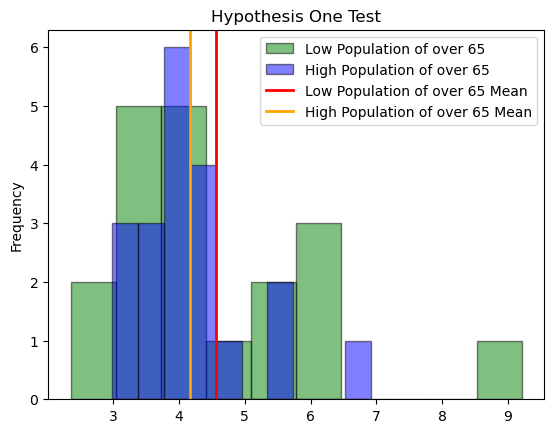

In [86]:
plt.hist(low65['Rates of Infection'], bins=10, ec='black', 
         alpha = 0.5, color='g', label='Low Population of over 65')
plt.hist(high65['Rates of Infection'], bins=10, ec='black', 
         alpha = 0.5, color='b', label='High Population of over 65')

plt.axvline(low65['Rates of Infection'].mean(), color='red', linewidth=2, label='Low Population of over 65 Mean') 
plt.axvline(high65['Rates of Infection'].mean(), color='orange',  linewidth=2, label='High Population of over 65 Mean') 

plt.title('Hypothesis One Test')
plt.ylabel('Frequency')
plt.legend()

#### Second hypothesis test: Do counties in GA with larger populations of people over the age of 18 have higher rates of infection compared to counties with small populations of people over the age of 18?

1. **Null Hypothesis (H0)**
    - There is no difference between the rate of infection between counties with high population of people over 18 compared to counties with low populations of people over 18.
    
2. **Alternate hypothesis (H1)**
    - There is a difference between the rate of infection between counties with high population of people over 18 compared to counties with low populations of people over 18.

In [87]:
# use of median to gets us a even split of the column values.
middle18 = testing['18 years and over'].median()

#split into two dataframes
low18 = testing[testing['18 years and over'] < middle18][['Rates of Infection', '18 years and over']]
high18 = testing[testing['18 years and over'] >= middle18][['Rates of Infection',  '18 years and over']]

# used to test hypothesis two sample.
t_value, p_value = stats.ttest_ind(a= low18['Rates of Infection'], b= high18['Rates of Infection'],
                equal_var=False)

print('T_value:', t_value)
print('P_value:', p_value)

alpha = 0.05
print('Alpha Value: ', alpha)

if p_value<=alpha:
    print('We can reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

T_value: 0.3338652062755249
P_value: 0.7407956406126108
Alpha Value:  0.05
We fail to reject the null hypothesis.


#### Here we fail to reject the null hypothesis because the p-value is to high for our alpha level of 0.05. 
So, we can confidently say that there is no difference between the rate of infection between counties with high population of people over 18 compared to counties with low populations of people over 18.
Once again we can plot the data on a Histogram to visualize it.

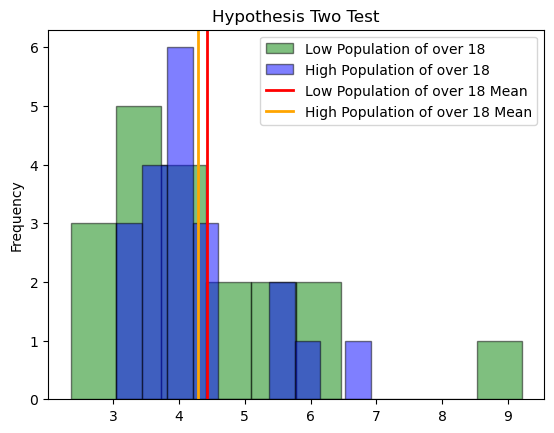

In [88]:
plt.hist(low18['Rates of Infection'], bins=10, ec='black', 
         alpha = 0.5, color='g', label='Low Population of over 18')
plt.hist(high18['Rates of Infection'], bins=10, ec='black', 
         alpha = 0.5, color='b', label='High Population of over 18')

plt.axvline(low18['Rates of Infection'].mean(), color='red', linewidth=2, label='Low Population of over 18 Mean') 
plt.axvline(high18['Rates of Infection'].mean(), color='orange',  linewidth=2, label='High Population of over 18 Mean') 

plt.title('Hypothesis Two Test')
plt.ylabel('Frequency')
plt.legend()

#### Third hypothesis test: Do counties in GA with higher populations of males have higher numbers of cases compared to counties with small populations of people who are male?

1. **Null Hypothesis (H0)**
    - There is no difference between the numbers of cases between counties with high population of males compared to counties with low males populations.
    
2. **Alternate hypothesis (H1)**
    - There is a difference between the numbers of cases between counties with high population of males compared to counties with low males populations.

In [89]:
# use of median to gets us a even split of the column values.
middleMale = testing['Ratio of Males to Pop'].median()

#split into two dataframes
# we'll use 2021-01-01 to use for number of cases.
lowMale = testing[testing['Ratio of Males to Pop'] < middleMale][['2021-01-01', 'Ratio of Males to Pop']]
highMale = testing[testing['Ratio of Males to Pop'] >= middleMale][['2021-01-01', 'Ratio of Males to Pop']]

# used to test hypothesis two sample.
t_value, p_value = stats.ttest_ind(a=lowMale['2021-01-01'], b=highMale['2021-01-01'],
                equal_var=False)

print('T_value:', t_value)
print('P_value:', p_value)

alpha = 0.05
print('Alpha Value: ', alpha)

if p_value<=alpha:
    print('We can reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

T_value: 0.9846232888206884
P_value: 0.3316560901698995
Alpha Value:  0.05
We fail to reject the null hypothesis.


#### Again, we fail to reject the null hypothesis because the p-value is to high for our alpha level of 0.05. 
So, we can confidently say that there is no difference between the numbers of cases between counties with high population of males compared to counties with low males populations.
- Again we can plot the data on a Histogram to visualize it.

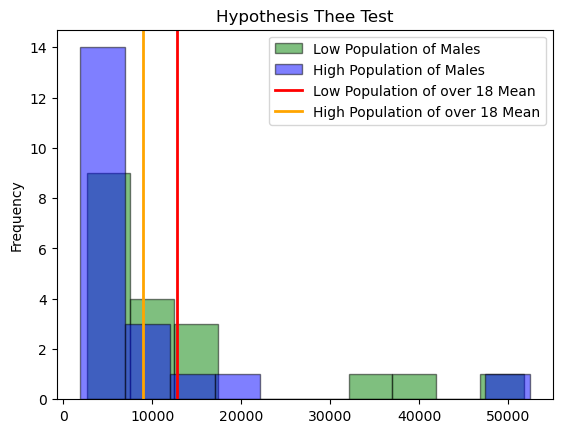

In [90]:
plt.hist(lowMale['2021-01-01'], bins=10, ec='black', 
         alpha = 0.5, color='g', label='Low Population of Males')
plt.hist(highMale['2021-01-01'], bins=10, ec='black', 
         alpha = 0.5, color='b', label='High Population of Males')

plt.axvline(lowMale['2021-01-01'].mean(), color='red', linewidth=2, label='Low Population of over 18 Mean') 
plt.axvline(highMale['2021-01-01'].mean(), color='orange',  linewidth=2, label='High Population of over 18 Mean') 

plt.title('Hypothesis Thee Test')
plt.ylabel('Frequency')
plt.legend()

#### With the three hypothesis test that were performed they were all three two sampled t-test in which one column was split into two one that was on the low end and one that was on the high end. The hypothesis test were then run. If see if there was a difference between the high and low subsets. But in all three test the test yielded in high p-values which meant that between the high and the low there was no significant difference between the populations.